In [4]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import csv
import pathlib
import os
import networkx as nx 
import matplotlib as mpl
import mpl_toolkits 
from mpl_toolkits.basemap import Basemap as Basemap
from PIL import Image

%matplotlib inline

# Function Defenition

## Util


In [5]:
def create_directory_if_not_exists(directory_path):
    """
    Create a directory if it does not exist.

    Args:
        directory_path (str): The path of the directory to create.
    """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created successfully.")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [22]:
def extract_float_h2_percent(input_string):
    parts = input_string.split('_')
    return float(parts[5])

def extract_float_co2_percent(input_string):
    parts = input_string.split('_')
    return float(parts[7])

def extract_float_sf_percent(input_string):
    parts = input_string.split('_')
    return float(parts[11])


In [75]:
def combine_images(new_image_dir,new_image_name,image_1_path, image_2_path):

    # Open the two PNG images
    image1 = Image.open(image_1_path)
    image2 = Image.open(image_2_path)

    # Get the dimensions of the first image
    width1, height1 = image1.size

    # Get the dimensions of the second image
    width2, height2 = image2.size

    # Create a new image with a white background and the dimensions to accommodate both images
    new_width = width1 + width2
    new_height = max(height1, height2)

    # Create a blank image with a white background and the new dimensions
    stitched_image = Image.new("RGBA", (new_width, new_height), (255, 255, 255, 255))

    # Paste the first image onto the new image at (0, 0)
    stitched_image.paste(image1, (0, 0))

    # Paste the second image onto the new image at (width1, 0)
    stitched_image.paste(image2, (width1, 0))

    # Save the stitched image
    stitched_image.save(new_image_dir+new_image_name+".png")

    # Close the original images
    image1.close()
    image2.close()


## Data Wrangling Functions

In [7]:
#Get all scenarios in a directory

def get_scenario_names(sen_name):
    lst = os.listdir(os.getcwd())
    lst = list(filter(lambda k: sen_name in k, lst))
    lst = list(filter(lambda k: '.jl' not in k, lst))
    lst = list(filter(lambda k: 'DACNon' not in k, lst))
    
    return lst

def create_fig_dir(directory):
    if not os.path.exists(directory):
        os.mkdir(directory)
        print("Directory created successfully")
    else:
        print("Directory already exists")

def read_cost_data(dir_list, scenario_name_dict, directory_name="./"):
    
    costs_df = pd.DataFrame(columns=["scenario_name", "co2_percent", "h2_percent", "sf_percent", "total_cost", "Power", "H2", "CO2", "SynFuels", "ConvFuels"])

    for dir_name in dir_list:
        
        curr_results_directory =  directory_name + dir_name + "/Results/"
        
        
        cost_df = pd.read_csv(curr_results_directory + "costs_system.csv")
        total_cost = cost_df[cost_df['Costs'] == "cTotal"]['Total'].values[0] * 1e-9
        
        total_cost = cost_df[cost_df['Costs'] == "cTotal"]['Total'].values[0] * 1e-9
        power_cost = cost_df[cost_df['Costs'] == "cPower_Total"]['Total'].values[0] * 1e-9
        h2_cost = cost_df[cost_df['Costs'] == "cHSC_Total"]['Total'].values[0] * 1e-9
        csc_cost = cost_df[cost_df['Costs'] == "cCSC_Total"]['Total'].values[0] * 1e-9
        sf_cost = cost_df[cost_df['Costs'] == "cSF_Prod"]['Total'].values[0] * 1e-9
        conv_fuel_cost = cost_df[cost_df['Costs'] == "cConv_Fuels"]['Total'].values[0] * 1e-9
          
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)
        
        curr_costs_df = pd.DataFrame(index = [scenario_name_dict[dir_name]],
                                     columns=["scenario_name", "co2_percent", "h2_percent", "sf_percent", "total_cost", "Power", "H2", "CO2", "SynFuels", "ConvFuels"],
                                     data=[[scenario_name_dict[dir_name], co2_percent, h2_percent, sf_percent, total_cost, power_cost, h2_cost, csc_cost, sf_cost, conv_fuel_cost]])

        costs_df = costs_df.append(curr_costs_df)
    

    return costs_df


In [8]:
def read_power_data(dir_list, scenario_name_dict, directory_name ="./"):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []
    power_gen_zone_list = []
    power_zone_list = []
    power_capacity_zone_list = []

    for dir_name in dir_list:
        
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)

        curr_dir_name = directory_name + dir_name + "/Results/"

        resource_dict = {'CCGT' : 'Gas', 'OCGT' : 'Gas', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind - Offshore' , 'offwind-ac' : 'Wind - Offshore', 'onwind' : 'Wind - Onshore',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv(curr_dir_name + "/power.csv").drop([0,1])
        weights_df = pd.read_csv(curr_dir_name + "/time_weights.csv")
        capacity_df = pd.read_csv(curr_dir_name + "/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})
        
        zones = power_long_df["zone"].unique()

        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','resource_type']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()
        power_zone_df = power_zone_df.assign(generation_twh = power_zone_df["value"] * 0.000001)
        power_zone_df['scenario'] = scenario_name_dict[dir_name]
        power_zone_df['zone'] = power_zone_df['zone'].str[0:3]
        power_zone_list.append(power_zone_df)

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name],
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        power_gen_list.append(power_gen_total_df)


        ######Generator Capacity##########

        #Aggregate capacity total capacity
        end_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_capacity_scenario_df = end_capacity_scenario_df.assign(capacity_gw = end_capacity_scenario_df["EndCap"] * 0.001).reset_index().assign(scenario = scenario_name_dict[dir_name] ,
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        
        end_capacity_zone_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type','zone']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name] ,
                                                      co2_percent = co2_percent , h2_percent = h2_percent, sf_percent = sf_percent)

        
        power_cap_list.append(end_capacity_scenario_df)
        power_capacity_zone_list.append(end_capacity_zone_scenario_df)
        ######Battery Capacity###########

        end_battery_capacity_scenario_df = capacity_df.query("Resource != 'Total'").assign(zone = capacity_df["Resource"].str[:5],
                       resource_type = capacity_df["Resource"].str[6:]).replace({"resource_type": resource_dict}).groupby(['resource_type']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[dir_name])

        end_battery_capacity_scenario_df = end_battery_capacity_scenario_df.assign(capacity_mw = end_battery_capacity_scenario_df["EndEnergyCap"]).reset_index()

        power_battery_cap_list.append(end_battery_capacity_scenario_df)
        
        ######Comp Power and Capacity DF#####
        
        comb_power_capacity_df = pd.merge(power_gen_total_df, end_capacity_scenario_df, on = ['resource_type', 'scenario'])
        comb_power_capacity_df["cf"] = comb_power_capacity_df.gen / comb_power_capacity_df.EndCap / 8760
        
        comb_power_capacity_list.append(comb_power_capacity_df)
        
    return power_gen_list, power_cap_list, power_battery_cap_list, comb_power_capacity_list, power_zone_list, power_capacity_zone_list
    
    


In [9]:
def read_fossil_fuel_data(dir_list, scenario_name_dict, directory_name ="./"):
    
    all_fuel_cons_list = []

    for dir_name in dir_list:
        
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)

        
        curr_dir_name = directory_name + dir_name + "/Results/"
        
        ###H2 Fuel Consumption
        h2_df = pd.read_csv(curr_dir_name + "/Results_HSC/HSC_h2_generation_discharge.csv").iloc[1].to_frame().iloc[1:-1]
        h2_df.columns = ["Generation"]
        h2_df.index.name = None  # Removing the index name
        # Renaming the index
        h2_df = h2_df.rename_axis('H2_Resource')
        
        hsc_generator_data_df = pd.read_csv(curr_dir_name + "../HSC_generation.csv")[['H2_Resource', 'etaFuel_MMBtu_p_tonne', 'Fuel']].set_index('H2_Resource')
        
        h2_df = h2_df.join(hsc_generator_data_df)
        h2_df['fuel_cons'] = h2_df['Generation'] * h2_df['etaFuel_MMBtu_p_tonne']
        hsc_fuel_cons_df = h2_df.groupby('Fuel')[['fuel_cons']].sum()
        
        hsc_fuel_cons_df = hsc_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                  sector = "H2").reset_index()
        
        ###Power Fuel Consumption
        power_df = pd.read_csv(curr_dir_name + "/power.csv").iloc[1].to_frame().iloc[1:-1]
        power_df.columns = ["Generation"]
        power_df.index.name = None  # Removing the index name

        # Renaming the index
        power_df = power_df.rename_axis('Resource')
        
        generator_data_df = pd.read_csv(curr_dir_name + "../Generators_data.csv")[['Resource', 'Heat_Rate_MMBTU_per_MWh', 'Fuel']].set_index('Resource')
        
        power_df = power_df.join(generator_data_df)
        power_df['fuel_cons'] = power_df['Generation'] * power_df['Heat_Rate_MMBTU_per_MWh']
        power_fuel_cons_df = power_df.groupby('Fuel')[['fuel_cons']].sum()
        
        power_fuel_cons_df = power_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                   sector = "Power").reset_index()
        
        ###DAC Fuel Consumption
        csc_df = pd.read_csv(curr_dir_name + "/Results_CSC/CSC_DAC_capacity.csv").rename(columns = {"Resource" : "CO2_Resource"})
        csc_df = (csc_df[csc_df["CO2_Resource"] != "Total"]).set_index('CO2_Resource')
        dac_data_df = pd.read_csv(curr_dir_name + "../CSC_capture.csv")[['CO2_Resource', 'etaFuel_MMBtu_per_tonne', 'Fuel']].set_index('CO2_Resource')
        csc_df = dac_data_df.join(csc_df)
        
        
        csc_df['fuel_cons'] = csc_df['Annual_Capture'] * csc_df['etaFuel_MMBtu_per_tonne']
        csc_fuel_cons_df = csc_df.groupby('Fuel')[['fuel_cons']].sum()
        
        csc_fuel_cons_df = csc_fuel_cons_df.assign(scenario = scenario_name_dict[dir_name],
                                                   co2_percent = co2_percent ,
                                                   h2_percent = h2_percent,
                                                   sf_percent = sf_percent, 
                                                   sector = "CSC").reset_index()
        
        
        
        ### Liquid Fuel Consumption
        
        syn_diesel_demand = pd.read_csv(curr_dir_name + "/Results_SynFuels/Synfuel_diesel_production.csv").iloc[1,-1:].sum()
        syn_gasoline_demand = pd.read_csv(curr_dir_name + "/Results_SynFuels/Synfuel_gasoline_production.csv").iloc[1,-1:].sum()
        
        diesel_demand = pd.read_csv(curr_dir_name + "../Liquid_Fuels_Diesel_Demand.csv").iloc[:,4:].astype(float).sum().sum() - syn_diesel_demand
        gasoline_demand = pd.read_csv(curr_dir_name + "../Liquid_Fuels_Gasoline_Demand.csv").iloc[:,4:].astype(float).sum().sum() - syn_gasoline_demand
        
        diesel_demand_df = pd.DataFrame({'Fuel': ['Diesel'],
                                         'fuel_cons':[diesel_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})
        
        syn_diesel_demand_df = pd.DataFrame({'Fuel': ['SynDiesel'],
                                         'fuel_cons':[syn_diesel_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})
        
        gasoline_demand_df = pd.DataFrame({'Fuel': ['Gasoline'],
                                         'fuel_cons':[gasoline_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})
        
        syn_gasoline_demand_df = pd.DataFrame({'Fuel': ['SynGasoline'],
                                         'fuel_cons':[syn_gasoline_demand], 
                                         'scenario': [scenario_name_dict[dir_name]],
                   'co2_percent': [co2_percent],
                   'h2_percent': [h2_percent],
                    'sf_percent':[sf_percent],
                   'sector': ['Trans']})

        all_fuel_cons = pd.concat([power_fuel_cons_df, hsc_fuel_cons_df, csc_fuel_cons_df, diesel_demand_df, gasoline_demand_df, syn_diesel_demand_df, syn_gasoline_demand_df]).query("Fuel != 'None' and Fuel != 'uranium' and Fuel != 'biomass'")
        all_fuel_cons["Fuel"] = all_fuel_cons["sector"]  + "_" + all_fuel_cons["Fuel"]
        
        
        all_fuel_cons_list.append(all_fuel_cons.reset_index())
        
        
    return pd.concat(all_fuel_cons_list)



In [10]:
def read_power_data_gas_granular(dir_list):
    
    power_cap_list = []
    power_gen_list = []
    power_battery_cap_list = []
    comb_power_capacity_list = []

    for dir_name in dir_list:

        resource_dict = {'CCGT' : 'Gas_CCGT', 'OCGT' : 'Gas_OCGT', 'CCGT_CCS' : 'Gas w/ CCS',
             'biomass' : 'Biomass',
             'coal' :'Coal',
             'lignite' : 'Coal',
             'oil' : 'Oil',
             'offwind-dc' : 'Wind' , 'offwind-ac' : 'Wind', 'onwind' : 'Wind',
            'ror' : 'Hydro', 'hydro' : 'Hydro', 'PHS' : 'PHS',
             'solar' : 'Solar',
            'nuclear' : 'Nuclear'}

        #Raw Data
        power_df = pd.read_csv("./" + dir_name + "/Results/power.csv").drop([0,1])
        weights_df = pd.read_csv("./" + dir_name + "/Results/time_weights.csv")
        capacity_df = pd.read_csv("./" + dir_name + "/Results/capacity.csv")

        #########Power###########

        #Wrangle Power Data into long format
        power_long_df = power_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        power_long_df = power_long_df.assign(zone = power_long_df["variable"].str[:5],
                                 resource_type = power_long_df["variable"].str[6:],
                                interval = pd.to_numeric(power_long_df["Resource"].str[1:]) ).replace({"resource_type": resource_dict})

        zones = power_long_df["zone"].unique()

        power_total_df = power_long_df.query("zone == 'Total'")
        #Add weights to long power data frame
        power_long_df = power_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        #Aggregate power data by zone
        power_zone_df = power_long_df.groupby(['zone','interval']).agg({'value': 'sum'}).query("zone != 'Total'").reset_index()

        power_gen_df = power_long_df.query("variable != 'Total'").groupby(['resource_type','interval']).agg({'value': 'sum'}).reset_index()

        #Aggregate power by generator type
        power_gen_total_df = power_long_df.query("variable != 'Total'").assign(gen = power_long_df["value"] * power_long_df["Weight"]).groupby(['resource_type']).agg({'gen': 'sum'}).reset_index()
        power_gen_total_df = power_gen_total_df.assign(generation_twh = power_gen_total_df["gen"] * 0.000001, scenario = scenario_name_dict[dir_name])

        power_gen_list.append(power_gen_total_df)


    return power_gen_list
    
    

In [11]:
def read_h2_data(h2_dir_list,scenario_name_dict, directory_name):

    h2_cap_list = []
    h2_gen_list = []
    h2_stor_cap_list = []
    
    for h2_dir_name in h2_dir_list:
        
        co2_percent = extract_float_co2_percent(h2_dir_name)
        h2_percent = extract_float_h2_percent(h2_dir_name)
        sf_percent = extract_float_sf_percent(h2_dir_name)

        
        curr_dir_name = directory_name + h2_dir_name + "/Results/Results_HSC/"
        curr_dir_name_short = directory_name + h2_dir_name + "/Results/"

        h2_discharge_df = pd.read_csv(curr_dir_name + "HSC_h2_generation_discharge.csv").drop([0,1])
        weights_df = pd.read_csv(curr_dir_name_short +  "time_weights.csv")
        h2_capacity_df = pd.read_csv(curr_dir_name + "HSC_generation_storage_capacity.csv")

        h2_discharge_long_df = h2_discharge_df.melt(id_vars = "Resource").query("Resource != 'Zone' & Resource != 'AnnualSum'")

        h2_discharge_long_df =  h2_discharge_long_df.assign(
                                interval = pd.to_numeric(h2_discharge_long_df["Resource"].str[1:]) )

        h2_discharge_long_df = h2_discharge_long_df.merge(weights_df, left_on = "interval", right_on = "Time", how = "left")

        mask = h2_discharge_long_df["variable"].str.contains("Above_ground_storage")
        h2_discharge_long_df = h2_discharge_long_df[~mask]

        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("SMR_w_CCS"),"resource_type"] = "SMR w/ CCS"
        h2_discharge_long_df.loc[h2_discharge_long_df["variable"].str.contains("SMR(?![\w\s]*CCS)"), "resource_type"] = "SMR"



        h2_discharge_total_df = h2_discharge_long_df.query("variable != 'Total'").assign(h2_prod = h2_discharge_long_df["value"] * h2_discharge_long_df["Weight"]*0.001).groupby(['resource_type']).agg({'h2_prod': 'sum'}).reset_index()
        h2_discharge_total_df = h2_discharge_total_df.assign(scenario = scenario_name_dict[h2_dir_name],
                                                             co2_percent = co2_percent, h2_percent = h2_percent, sf_percent = sf_percent)

        h2_gen_list.append(h2_discharge_total_df)

        mask = h2_capacity_df["Resource"].str.contains("storage")
        h2_storage_capacity_df = h2_capacity_df[mask]
        h2_capacity_df = h2_capacity_df[~mask]


        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Electrolyzer"),"resource_type"] = "Electrolyzer"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_ATR_wCCS"),"resource_type"] = "ATR w/ CCS"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("SMR_w_CCS"),"resource_type"] = "SMR w/ CCS"
        h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("SMR(?![\w\s]*CCS)"), "resource_type"] = "SMR"

        h2_storage_capacity_df["Resource"] = "Storage"

        
        end_capacity_scenario_df = h2_capacity_df.query("Resource != 'Total'").groupby(['resource_type']).agg({'EndCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name],
                                                             co2_percent = co2_percent, h2_percent = h2_percent, sf_percent = sf_percent).reset_index()

        h2_cap_list.append(end_capacity_scenario_df)
        
        end_storage_scenario_df = h2_storage_capacity_df.groupby(['Resource']).agg({'EndEnergyCap': 'sum'}).assign(scenario = scenario_name_dict[h2_dir_name]).reset_index()

        h2_stor_cap_list.append(end_storage_scenario_df)
        
    return h2_gen_list, h2_cap_list,h2_stor_cap_list


In [12]:
def read_emission_data(dir_list, scenario_dict, directory):

    emissions_df = pd.DataFrame(columns=["scenario_name", "h2_percent", "co2_percent", "sf_percent", "Power Plant Emissions", "Power Plant PSC Abatement",\
                                         "H2 Plant Emissions", "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement","DAC Fuel CCS", "CO2 Storage",\
                                         "SF CO2 In", "SF Plant Capture", "SynFuel Emissions", "Conventional Fuel Emissions"])

    for dir_name in dir_list:

        curr_dir_name = directory + dir_name + "/Results/"
        
        curr_power_em = pd.read_csv(curr_dir_name+"emissions.csv")
        curr_em_price = pd.read_csv(curr_dir_name+"emissions.csv").iloc[0,1]*-1
        #Power plant emissions
        curr_power_em = pd.read_csv(curr_dir_name+"emissions.csv").iloc[1,11] * 1e-6
    
        #Hydrogen Emissions
        curr_hsc_em = pd.read_csv(curr_dir_name+"Results_HSC/HSC_emissions.csv").iloc[0,11]* 1e-6
             
        # read the Excel file
        sf_emissions_df = pd.read_csv(curr_dir_name+'Results_SynFuels/Syn_Fuel_Emissions_Balance.csv', header=None).iloc[:3].drop(1)        
        # Set the column names as the values in the third row
        sf_emissions_df.columns = sf_emissions_df.iloc[0]
        
        sf_co2_in = sf_emissions_df.iloc[1]['CO2_In'].astype(float).sum()*1e-6
        sf_emissions = sf_emissions_df.iloc[1]['SF_Prod_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Jetfuel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Diesel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['SF_Gasoline_Cons_Emissions'].astype(float).sum()*1e-6 + \
                        sf_emissions_df.iloc[1]['ByProd_Cons_Emissions_1'].astype(float).sum()*1e-6
        conv_fuel_emissions = sf_emissions_df.iloc[1]['Conv_Diesel_Cons_Emissions'].astype(float).sum()*1e-6 + \
                            sf_emissions_df.iloc[1]['Conv_Gasoline_Cons_Emissions'].astype(float).sum()*1e-6 + \
                            sf_emissions_df.iloc[1]['Conv_Jetfuel_Cons_Emissions'].astype(float).sum()*1e-6
        
        
        capture_zone_balance_df = pd.read_csv(curr_dir_name + 'Results_CSC/Zone_CO2_storage_balance.csv', header =None).iloc[:3].drop(1)
        capture_zone_balance_df.columns = capture_zone_balance_df.iloc[0] 
       
        emission_zone_balance_df = pd.read_csv(curr_dir_name + 'Results_CSC/Zone_CO2_emission_balance.csv', header =None).iloc[:3].drop(1)
        emission_zone_balance_df.columns = emission_zone_balance_df.iloc[0]
        
        curr_power_cc = -1 * capture_zone_balance_df.iloc[1]['Power CCS'].astype(float).sum()*1e-6
        curr_h2_cc = -1 * capture_zone_balance_df.iloc[1]['H2 CCS'].astype(float).sum()*1e-6
        curr_sf_cc = -1 * capture_zone_balance_df.iloc[1]['Synfuel Production Capture'].astype(float).sum()*1e-6
        curr_co2_stor = -1 * capture_zone_balance_df.iloc[1]['CO2 Storage'].astype(float).sum()*1e-6
        curr_dac_cc = -1 * capture_zone_balance_df.iloc[1]['DAC Capture'].astype(float).sum() *1e-6#+ 
                            #capture_zone_balance_df.iloc[1]['DAC Fuel CCS'].astype(float).sum())*1e-6
        curr_dac_fuel_ccs = -1 * capture_zone_balance_df.iloc[1]['DAC Fuel CCS'].astype(float).sum()*1e-6
               
        curr_dac_em = emission_zone_balance_df.iloc[1]['DAC Emissions'].astype(float).sum()*1e-6 +\
                        emission_zone_balance_df.iloc[1]['CO2 Pipeline Loss'].astype(float).sum()*1e-6
                        
        curr_power_em = curr_power_em + curr_power_cc * -1
        curr_hsc_em = curr_hsc_em + curr_h2_cc * -1
        
        co2_percent = extract_float_co2_percent(dir_name)
        h2_percent = extract_float_h2_percent(dir_name)
        sf_percent = extract_float_sf_percent(dir_name)
        
        curr_emissions_df = pd.DataFrame(index = [scenario_dict[dir_name]],\
                                         columns=["scenario_name", "h2_percent", "co2_percent", "sf_percent", "Power Plant Emissions", 
                                                  "Power Plant PSC Abatement", "H2 Plant Emissions", \
                                                  "H2 Plant PSC Abatement", "DAC Plant Emissions", "DAC Abatement", "DAC Fuel CCS", "CO2 Storage",\
                                                  "SF CO2 In","SF Plant Capture", "SynFuel Emissions", "Conventional Fuel Emissions", "co2_price"], \
                                         data=[[scenario_dict[dir_name], h2_percent, co2_percent, sf_percent, curr_power_em, curr_power_cc, curr_hsc_em, \
                                                curr_h2_cc, curr_dac_em, curr_dac_cc, curr_dac_fuel_ccs, curr_co2_stor,\
                                                sf_co2_in, curr_sf_cc, sf_emissions, conv_fuel_emissions, curr_em_price]])
        
        emissions_df = emissions_df.append(curr_emissions_df)
        
    emissions_summary_df = pd.DataFrame()
    emissions_summary_df["Net Power Plant Emissions"] = emissions_df["Power Plant Emissions"] 
    emissions_summary_df["Net H2 Plant Emissions"] = emissions_df["H2 Plant Emissions"] 
    emissions_summary_df["Net DAC Plant Emissions"] = emissions_df["DAC Plant Emissions"] + emissions_df["DAC Abatement"]
    #emissions_summary_df["SF Emissions"] = emissions_df["SF Emissions"]
    
    
    return emissions_df, emissions_summary_df


In [13]:
def read_h2_balance(h2_dir_list):
    
    h2_balance = []
    
    zone_dict = {"1" : "Belguim",
                "2" : "Germany",
                "3" : "Denmark_1",
                "4" : "Denmark_2",
                "5" : "France",
                "6" : "UK_1",
                "7" : "UK_2",
                "8" : "Netherlands",
                "9" : "Norway",
                "10" : "Sweden",}
    
    for h2_dir_name in h2_dir_list:
        curr_h2_balance_df = pd.read_csv("./" + h2_dir_name + "/Results/Results_HSC/HSC_h2_balance.csv", index_col = 0, header = None).head(3)#.melt()
        curr_h2_balance_df = pd.DataFrame(data = {'scenario_name' : scenario_name_dict[h2_dir_name], 
                                                  'var' : curr_h2_balance_df.iloc[0],
                                                  'zone' :curr_h2_balance_df.iloc[1], 'value' :curr_h2_balance_df.iloc[2]}).reset_index()
        
        #curr_h2_balance_df.loc[curr_h2_balance_df["index"].str.contains("Genertation"),"resource_type"] = "Electrolyzer"
        #h2_capacity_df.loc[h2_capacity_df["Resource"].str.contains("Large_SMR"),"resource_type"] = "SMR"
        
        mask = curr_h2_balance_df["var"].str.contains("Generation")
        mask2 = curr_h2_balance_df["var"].str.fullmatch("Demand")
        
        curr_h2_balance_df = curr_h2_balance_df[mask | mask2]
        
        curr_h2_balance_df = curr_h2_balance_df.pivot(index = ['scenario_name', 'zone'], columns = ['var'], values = ['value']).reset_index()
        
        curr_h2_balance_df.columns = ["scenario", "zone", "demand", "generation"]
        
        curr_h2_balance_df[["demand", "generation"]] = curr_h2_balance_df[["demand", "generation"]].apply(pd.to_numeric)
        
        
        curr_h2_balance_df["demand"] = pd.Series(curr_h2_balance_df["demand"]) * -1
        
        curr_h2_balance_df = curr_h2_balance_df.replace({"zone": zone_dict})
        
        h2_balance.append(curr_h2_balance_df)

    return h2_balance


def fig_hydrogen_demand_supply_zonal(plot_df, title_str):
    
    scenario = plot_df["scenario"][0]

    labels = plot_df["zone"]
    demand = plot_df["demand"]
    generation = plot_df["generation"]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, demand, width, label='Demand')
    rects2 = ax.bar(x + width/2, generation, width, label='Generation')

    ax.set_ylabel('Hydrogen Demand (Tonnes)')
    ax.set_title(title_str + " " + scenario)

    ax.set_xticks(x) # values
    ax.set_xticklabels(labels, rotation = 45) # labels

    ax.legend()

## Plotting Functions

### Power and H2 Absolute

In [14]:
def compare_plot_ax_abs(i, group, relative, group_by_CO2_cap, ylim, y_label, plot_type, display_legend, subplot_titles, x_label, colors, ax):
        
    # Plot the data and set the axis labels and tick labels
    artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
    if y_label != None:
        ax.set_ylabel(y_label)
    else:
        ax.get_yaxis().set_ticks([])
        ax.yaxis.set_tick_params(labelleft=False)
    locs = ax.get_xticks()
    labels = [group.index[i] for i in range(len(group.index))]
    # Group the data based on the specified method
    
    labels = ["103 Mtonne", "155 Mtonne", "206 Mtonne", "258 Mtonne"]

    ax.grid(axis='y')
 
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    if x_label == True:
        ax.set_xticklabels(labels, rotation=70)
        ax.set_xlabel("CO2 Cap")
    else:
        ax.get_xaxis().set_ticks([])

    if display_legend == True:
        ax.set_title(subplot_titles, size = 12)
        
    return ax

    
def create_plots_groups_abs(plot_type, gen_list, order, index_ordered, group_by_CO2_cap, reorder_groups):
    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        y_label = "Total Power\nGeneration (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total PowerCapacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "h2_cap":
        data_col = "EndCap"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Capacity (TW)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(gen_list).query("h2_percent == 0.0").query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')
    
    # Extract the desired data column and convert units
    if plot_type == "h2":
        curr_df = curr_df[data_col] * (33.3*1e9*1e-12) 
    elif plot_type == "h2_cap":
        curr_df = curr_df[data_col] * (33.3*1e-3) 
    else:
        curr_df = curr_df[data_col]
    
    #curr_df = curr_df[data_col] * (1e3) if (plot_type == "h2_cap") else curr_df[data_col]
  
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2" or plot_type == "h2_cap":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
   
    grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))

    
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]
    groups_reordered =  [first_group] + remaining_groups

    return groups_reordered, colors


def fig_compare_abs(dir_name, gen_lists,h2_lists, title_str, index_ordered_list,  group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim_1 = None,ylim_2 = None,ylim_3 = None,ylim_4 = None,
                reorder_groups = True, subplot_titles = ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'], 
                column_titles = ["Baseline CO2 Storage", "NO Only CO2 Storage"]):    
    
    
    if 'order' in vars():
        order = order
    else:
        order = None
        
    groups_reordered_elec_gen = []
    groups_reordered_elec_cap = []
    groups_reordered_h2_gen = []
    groups_reordered_h2_cap = []
    
    for i, curr_gen_list in enumerate(gen_lists):
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = "elec",
                                                                   gen_list = curr_gen_list[0],
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_elec_gen.append(curr_groups_reorder)
        colors_elec_gen=curr_color
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = "elec_cap",
                                                                   gen_list = curr_gen_list[1],
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_elec_cap.append(curr_groups_reorder)
        colors_elec_cap=curr_color
        
    for i, curr_h2_list in enumerate(h2_lists):
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = 'h2',
                                                                   gen_list = curr_h2_list[0], 
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_h2_gen.append(curr_groups_reorder)
        colors_h2_gen=curr_color
        
        curr_groups_reorder, curr_color = create_plots_groups_abs(plot_type = 'h2_cap',
                                                                   gen_list = curr_h2_list[1], 
                                                                   order = order,
                                                                   index_ordered = index_ordered_list[i],
                                                                   group_by_CO2_cap = group_by_CO2_cap,
                                                                   reorder_groups=reorder_groups)
        
        groups_reordered_h2_cap.append(curr_groups_reorder)
        colors_h2_cap=curr_color
    
    
    # Determine number of subplots based on number of groups
    num_subplots = len(gen_lists)

    fig, (axes_r1, axes_r2, axes_r3, axes_r4) = plt.subplots(4, num_subplots,figsize=(6, 8))
        
    #fig.subplots_adjust(top=0.30, hspace=0.5)  # Adjust the top parameter for tighter spacing
    
    # Iterate over groups and plot each group in a separate subplot
    legend_artists = []
    
    for curr_subplot in range(num_subplots):
        if curr_subplot == 0:
            y_label_elec_gen = "Power Generation\n(TWh)"
            y_label_elec_cap = "Power Capacity\n(GW)"
            y_label_h2_gen = "H2 Generation\n(TWh)"
            y_label_h2_cap = "H2 Capacity\n(GW)"
        else:
            y_label_elec_gen = None
            y_label_elec_cap = None
            y_label_h2_gen = None
            y_label_h2_cap = None
            
        compare_plot_ax_abs(i = 0,
                            group = groups_reordered_elec_gen[curr_subplot][0][1],
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim_1, 
                            y_label = y_label_elec_gen,
                            plot_type = plot_type,
                            display_legend = True,
                            subplot_titles = column_titles[curr_subplot],
                            x_label = False,
                            colors = colors_elec_gen,
                            ax = axes_r1[curr_subplot])
        
        compare_plot_ax_abs(i = 0,
                        group = groups_reordered_elec_cap[curr_subplot][0][1],
                        relative = relative,
                        group_by_CO2_cap = group_by_CO2_cap,
                        ylim = ylim_2, 
                        y_label = y_label_elec_cap,
                        plot_type = plot_type,
                        display_legend = False,
                        subplot_titles = subplot_titles,
                        x_label = False,
                        colors = colors_elec_cap,
                        ax = axes_r2[curr_subplot])   
    
        compare_plot_ax_abs(i = 0,
                            group = groups_reordered_h2_gen[curr_subplot][0][1],
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim_3, 
                            y_label = y_label_h2_gen,
                            plot_type = plot_type,
                            display_legend = False,
                            subplot_titles = subplot_titles,
                            x_label = False,
                            colors = colors_h2_gen,
                            ax = axes_r3[curr_subplot])
        
        compare_plot_ax_abs(i = 0,
                            group = groups_reordered_h2_cap[curr_subplot][0][1],
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim_4, 
                            y_label = y_label_h2_cap,
                            plot_type = plot_type,
                            display_legend = False,
                            subplot_titles = subplot_titles,
                            x_label = True,
                            colors = colors_h2_cap,
                            ax = axes_r4[curr_subplot])
    
        
    # Set overall figure title and legend
    fig.suptitle(title_str, fontsize=14)
    
    handles, labels = axes_r1[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.26,0.90))
    
    plt.tight_layout(rect=[0, 0.03, 1.1, 0.95]) 
    plt.tight_layout()
    
    handles, labels = axes_r3[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor= (1.23,0.52))

    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
        
    
    return fig  



### Power and H2 Production Diff

In [226]:
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch


def compare_plot_ax(i, label, group, relative, group_by_CO2_cap, ylim, 
                    y_label, plot_type, display_legend, subplot_titles, 
                    x_label, colors, ax):
    
    if group.shape[0] < 3:
        # Create a new row of zeros
        new_row = pd.Series(0, index=group.columns)
        # Insert the new row as the first row
        group.loc[-1] = new_row
        group = group.iloc[np.arange(-1, len(group)-1)]
        
        ax.text(0, ylim[1]/2, "             Infeasible             ", fontsize=12, ha='center', va='center', bbox=dict(facecolor='dodgerblue'), rotation=90)

        
    reference_row = group.iloc[0]
    
    if relative == True:
        for col in group.columns:
            group[col] = group[col] - reference_row[col]
            

    # Plot the data and set the axis labels and tick labels
    artists = group.plot(kind='bar', stacked=True, legend = False, ax=ax, color=colors)
    ax.set_ylabel(y_label)
    locs = ax.get_xticks()

    ax.grid(axis='y')
    if ylim == None:
        if plot_type == "elec":
            ax.set_ylim([0,3400])
            if relative:
                ax.set_ylim([-100,150])
        elif plot_type == "elec_cap" :
            ax.set_ylim([0,1500])
            if relative:
                ax.set_ylim([-50,75])
        elif plot_type == "h2":
            ax.set_ylim([0,620])
            if relative:
                ax.set_ylim([-25,100])
        else:
            ax.set_ylim([0,10])

            if relative:
                ax.set_ylim([-200,200])       
    else:
        ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))

    if x_label != None:
        ax.set_xticklabels(x_label, rotation=70)
    else:
        ax.get_xaxis().set_ticks([])

    if subplot_titles != None:
        ax.set_title(subplot_titles, size = 10)
        
    return ax

    
def create_plots_groups(plot_type, gen_list, data_col, order, index_ordered, group_by_CO2_cap,
                        reorder_groups, subplot_titles = None, labels = None, co2_include = None):
    # Filter out unwanted dataframes
    new_gen_list = [df for df in gen_list if (df['co2_percent'].iloc[0] in co2_include)]
    
    if plot_type != "fuels":
        # Concatenate and pivot the input data
        curr_df = pd.concat(new_gen_list).query("resource_type != 'Battery' & resource_type != 'PHS'").pivot(index='scenario', columns='resource_type')
    else: 
        curr_df = new_gen_list.copy()
        curr_df['fuel_cons'] = curr_df['fuel_cons'] * 2.93071e-7
        curr_df = curr_df.pivot(index='scenario', columns='Fuel')  
        
    if plot_type == "h2":
        curr_df = curr_df[data_col] * (33.3*1e9*1e-12) 
    elif plot_type == "h2_cap":
        curr_df = curr_df[data_col] * (33.3*1e-3) 
    else:
        curr_df = curr_df[data_col]
    
    # Reorder and truncate the index labels
    curr_df = curr_df.reindex(index=index_ordered)
    curr_df.index = [label[:-21] for label in curr_df.index]
    
    if plot_type == "h2" or plot_type == "h2_cap":
        # Reorder the columns (i.e., the resource types)
        curr_df = curr_df[order]
        
    if subplot_titles != None:
        subplot_titles = subplot_titles
        labels = labels

    if group_by_CO2_cap:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% CO2 Cap)', expand=False))#.apply(lambda x: x.sort_index())
    else:
        grouped_df = curr_df.groupby(curr_df.index.str.extract('(\d+% H2)', expand=False))
               
    # Split the groups into the first group and the remaining groups
    groups = list(grouped_df)
    first_group = groups[0]
    remaining_groups = groups[1:]

    if reorder_groups == True:
        # Concatenate the remaining groups and the first group in reverse order
        groups_reordered = remaining_groups + [first_group]
    else:
        groups_reordered =  [first_group] + remaining_groups
        
    return groups_reordered


def fig_compare_new(dir_name, gen_lists, title_str, index_ordered_list, group_by_CO2_cap=False, 
                plot_type="elec", relative = True, scenario_save = "baseline", ylim = None,
                reorder_groups = True, subplot_titles = None, labels = None, y_labels = None,
                co2_include = True, legend_loc = [0,0]):    
    if plot_type == "elec":
        data_col = "generation_twh"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Total Generation Relative to Low H2 HDV (TWh)"
        else:
            y_label = "Total Generation (TWh)"
    elif plot_type == "elec_cap":
        data_col = "capacity_gw"
        y_label = "Total Capacity (TW)"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
    elif plot_type == "h2":
        data_col = "h2_prod"
        colors = ["green", "dodgerblue", "navy", "grey"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        if relative == True:
            y_label = "Total H2 Discharge Relative to Low H2 HDV (TWh)"
        else:
            y_label = "Total H2 Discharge (TWh)"
    elif plot_type == "h2_cap":
        data_col = "EndCap"
        colors = ["green", "grey", "pink", "dodgerblue"]
        order = ['Electrolyzer', 'ATR w/ CCS', 'SMR w/ CCS', 'SMR' ]
        y_label = "Total H2 Capacity (TW)"
    elif plot_type == "fuels":
        data_col = "fuel_cons"
        colors = ["lightseagreen", "black", "darkviolet", "red", "dodgerblue", "pink", "grey", "gold", "green", "springgreen"]
        if relative == True:
            y_label = "Fossil Fuel Consumption Relativeto Low H2 HDV (TWh)"
        else:
            y_label = "Fossil Fuel\nConsumption (TWh)"
    else:
        raise ValueError("Invalid plot_type. Must be 'elec' or 'h2'.")
    
    if 'order' in vars():
        order = order
    else:
        order = None
    
    groups_reordered_list = []
    
    # Convert co2_include values to percentage strings
    co2_include_str = [str(int(val * 100)) + "%" for val in co2_include]

    for i, curr_gen_list in enumerate(gen_lists):
        
         # Filter items based on co2_include list
        curr_index_ordered_list = [item for item in index_ordered_list[i] if any(inc in item.split(', ')[1] for inc in co2_include_str)]
        
        curr_groups_reordered = create_plots_groups(plot_type = plot_type,
                                                                       gen_list = curr_gen_list, 
                                                                       data_col = data_col,
                                                                       order = order,
                                                                       index_ordered = curr_index_ordered_list,
                                                                       group_by_CO2_cap = group_by_CO2_cap,
                                                                       reorder_groups=reorder_groups,
                                                                       subplot_titles = subplot_titles, 
                                                                        labels = labels,
                                                                        co2_include=co2_include)
        
        
        
        groups_reordered_list.append(curr_groups_reordered)
    
    # Determine number of subplots based on number of groups
    num_subplots = len(groups_reordered_list[0])
    fig, axes = plt.subplots(len(co2_include),len(gen_lists), sharey=True, sharex = True, figsize=(1.9 * len(gen_lists) , 4 * len(co2_include)))
    
    for j, curr_groups_reordered in enumerate(groups_reordered_list):
        for i, (label, group) in enumerate(curr_groups_reordered):
            
            if i == num_subplots -1:
                curr_x_label = labels
            else:
                curr_x_label = None
                
            if i == 0:
                display_legend = True
                curr_subplot_title = subplot_titles[j]
            else:
                display_legend = False
                curr_subplot_title = None

            ax = axes[i,j] if len(co2_include) > 1 else axes[j]
            
            compare_plot_ax(i = i,
                            label = label,
                            group = group,
                            relative = relative,
                            group_by_CO2_cap = group_by_CO2_cap,
                            ylim = ylim, 
                            y_label = y_labels[i],
                            plot_type = plot_type,
                            display_legend = display_legend,
                            subplot_titles = curr_subplot_title,
                            x_label = curr_x_label,
                            colors = colors,
                            ax = ax)
            
            def legend_without_duplicate_labels(ax):
                handles, labels = ax.get_legend_handles_labels()
                unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
                fig.legend(*zip(*unique), loc = "lower left", ncol = 3, bbox_to_anchor= (legend_loc[0],legend_loc[1]))
    
    legend_without_duplicate_labels(ax)

    plt.tight_layout(rect=[0, 0.03, 1.1, 0.95]) 
    plt.subplots_adjust(wspace=0.06, hspace=0.05)
    plt.suptitle(title_str, size = 14)
    fig.text(-0.02, 0.5, y_label, rotation="vertical", va="center", fontsize=12, ha = 'center')
    
    if plot_type == "elec":  
        plt.savefig(dir_name + 'Figures/elec_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "elec_cap":
        plt.savefig(dir_name + 'Figures/elec_cap_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2":
        plt.savefig(dir_name + 'Figures/h2_gen_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "h2_cap":
        plt.savefig(dir_name + 'Figures/h2_cap_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    elif plot_type == "fuels":
        plt.savefig(dir_name + 'Figures/fuels_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    
    return fig 

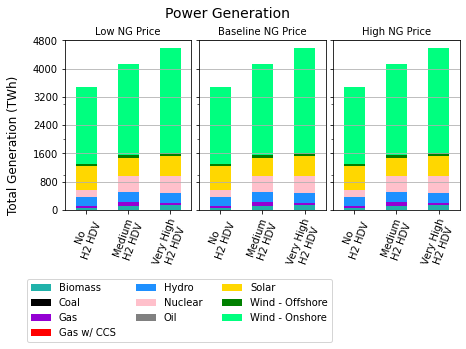

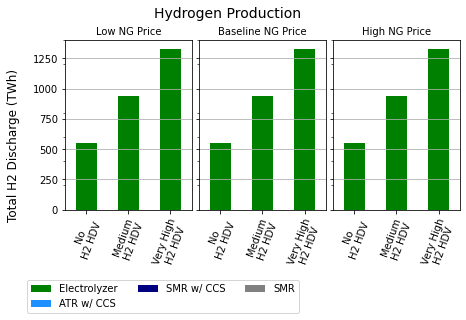

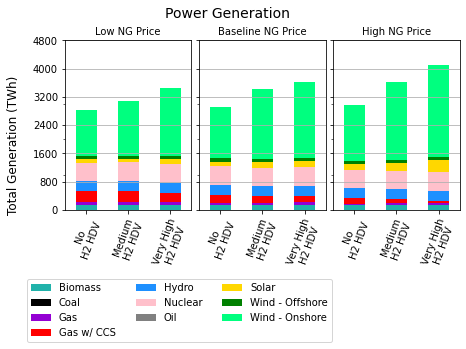

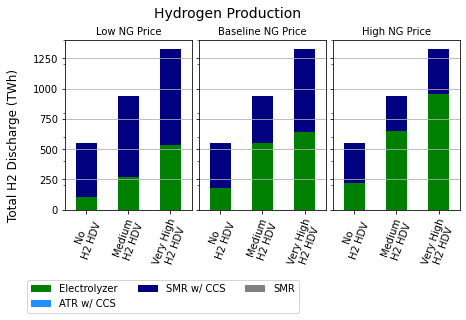

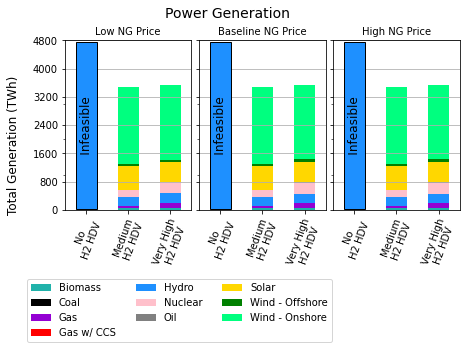

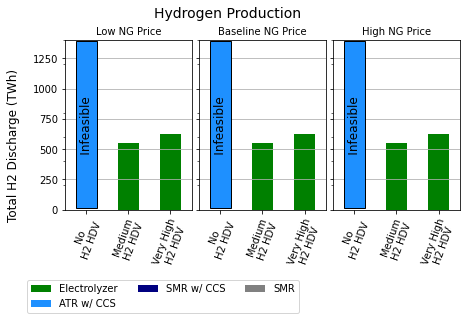

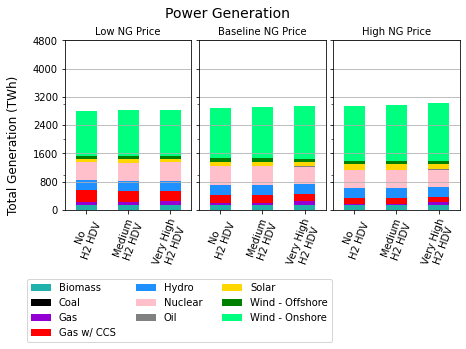

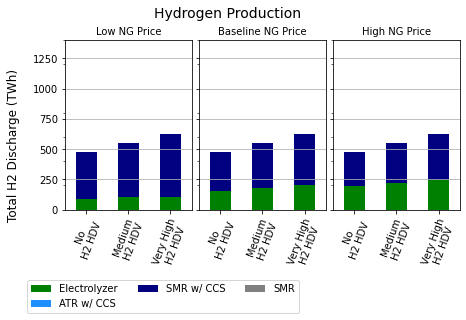

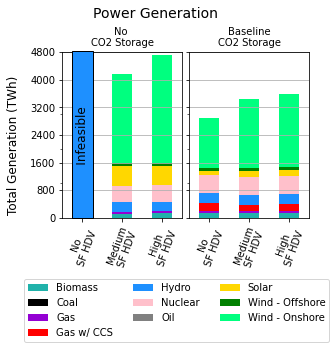

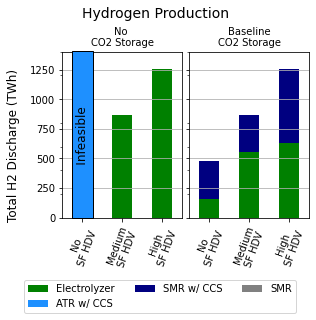

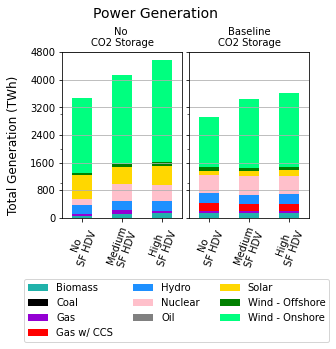

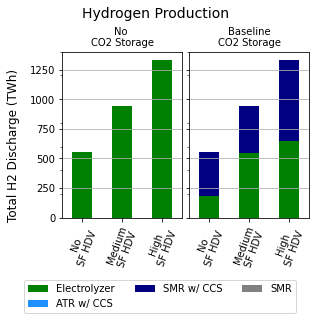

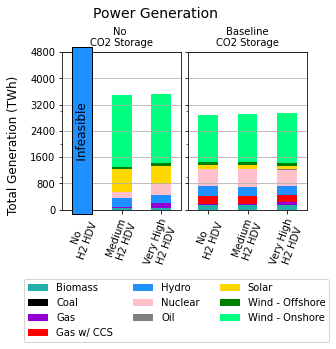

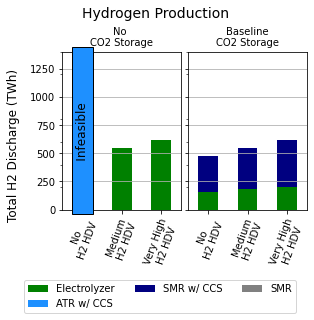

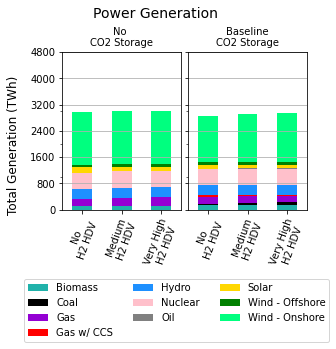

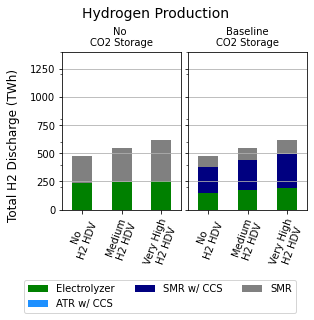

### Emissions 

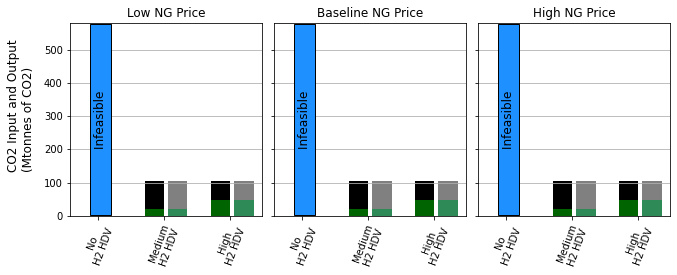

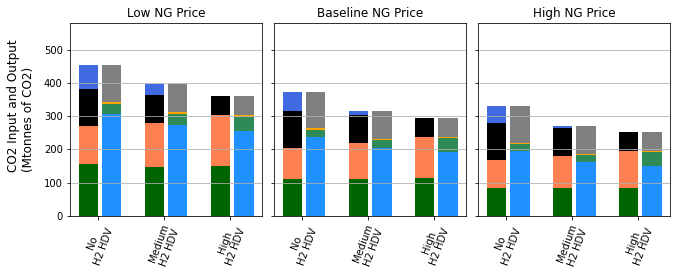

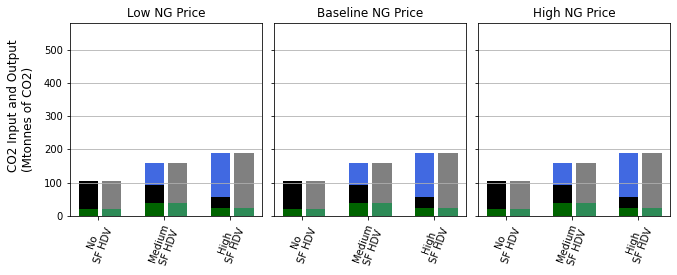

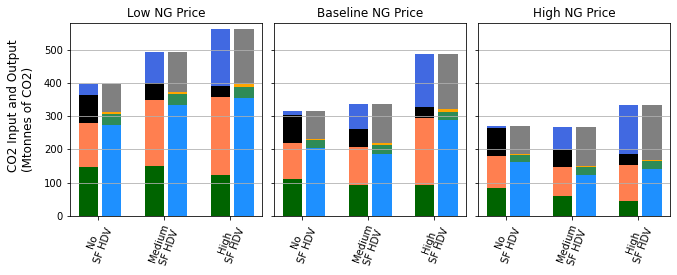

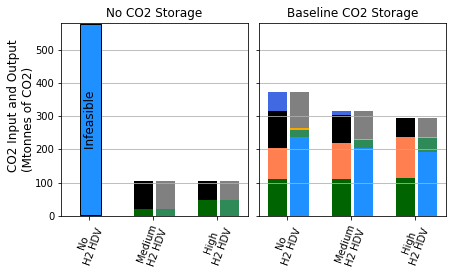

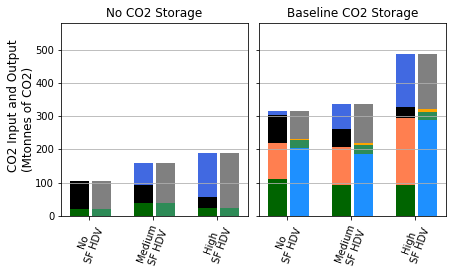

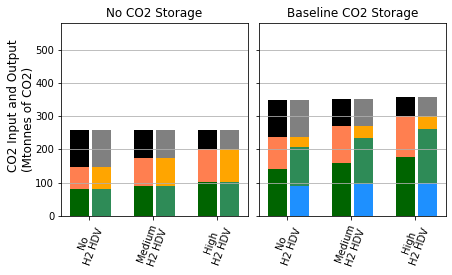

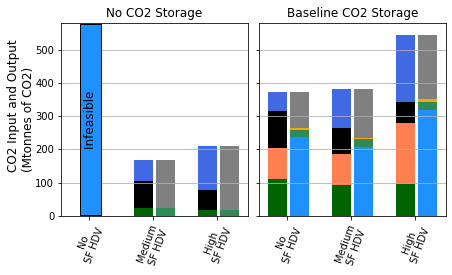

In [320]:
# Define the function to create the double stacked bar plot
def create_double_stacked_bar_plot(df, percent, y_limits = None, ax=None,
                                   subplot_title = None, fig_type = None, ax_sec = None,
                                  include_marginal_cost = False):

    filtered_df = df[df['co2_percent'] == percent].copy()
    
    co2_price = filtered_df['co2_price']
    
    # Calculate the new variable 'Liquid Fuel Emissions'
    filtered_df['Liquid Fuel Emissions'] = filtered_df['Conventional Fuel Emissions'] + filtered_df['SynFuel Emissions']
    # Calculate the new variables 'Power Sector Emissions' and 'HSC Emissions'
    filtered_df['Power Sector Emissions'] = filtered_df['Power Plant Emissions'] + filtered_df['Power Plant PSC Abatement']
    filtered_df['HSC Emissions'] = filtered_df['H2 Plant Emissions'] + filtered_df['H2 Plant PSC Abatement']
    filtered_df['DAC Abatement'] = filtered_df['DAC Abatement'] * -1  + filtered_df['DAC Fuel CCS'] * -1

    # Rename the columns
    filtered_df = filtered_df.rename(columns={
        'Power Plant Emissions': 'Power Fossil Fuel',
        'H2 Plant Emissions': 'Hydrogen Fossil Fuel',
        'Conventional Fuel Emissions': 'Conventional Liquid Fuel',
        'CO2 Storage': 'CO2 Sequestration',
        'DAC Abatement': 'DAC Abatement',
        'SynFuel Emissions': 'SynFuel Emissions'
    })
    

    if fig_type == "no_sf":
        # Group the filtered DataFrame by 'h2_percent' and sum the emissions columns
        grouped_df = filtered_df.groupby('h2_percent')[[
            'Power Fossil Fuel',
            'Hydrogen Fossil Fuel',
            'Conventional Liquid Fuel',
            'CO2 Sequestration',
            'DAC Abatement',
            'Power Sector Emissions',
            'HSC Emissions',
            'Liquid Fuel Emissions',  # Include the new variable
            'co2_price'
        ]].sum()
    else:
        grouped_df = filtered_df.groupby('sf_percent')[[
            'Power Fossil Fuel',
            'Hydrogen Fossil Fuel',
            'Conventional Liquid Fuel',
            'CO2 Sequestration',
            'DAC Abatement',
            'Power Sector Emissions',
            'HSC Emissions',
            'Liquid Fuel Emissions',  # Include the new variable
            'co2_price'
        ]].sum()
        

   
    if grouped_df.shape[0] < 3:
        # Create a new row of zeros
        new_row = pd.Series(0, index=grouped_df.columns)
        # Insert the new row as the first row
        grouped_df.loc[-1] = new_row
        grouped_df = grouped_df.iloc[np.arange(-1, len(grouped_df)-1)]
        ax.text(0.18, y_limits[1]/2, "                Infeasible                ", fontsize=12, ha='center', va='center', bbox=dict(facecolor='dodgerblue'), rotation=90)

    
    # Get the unique 'h2_percent' values for the x-axis
    h2_percent_values = grouped_df.index.tolist()

    # Define the width of each bar
    bar_width = 0.30

    # Create an array of indices for the x-axis positions
    x = np.arange(len(h2_percent_values))

    # Plot the first stacked bar (Power Fossil Fuel, Hydrogen Fossil Fuel, Conventional Liquid Fuel)
    ax.bar(x, grouped_df['Power Fossil Fuel'], bar_width, label='Power Fossil Fuel', color = 'darkgreen')
    ax.bar(x, grouped_df['Hydrogen Fossil Fuel'], bar_width, label='Hydrogen Fossil Fuel', bottom=grouped_df['Power Fossil Fuel'], color = 'coral')
    ax.bar(x, grouped_df['Conventional Liquid Fuel'], bar_width, label='Conventional Liquid Fossil Fuel', bottom=grouped_df['Power Fossil Fuel'] + grouped_df['Hydrogen Fossil Fuel'], color = 'black')
    ax.bar(x, grouped_df['DAC Abatement'], bar_width, label='CO2 Removal via DAC', bottom=grouped_df['Power Fossil Fuel'] + grouped_df['Hydrogen Fossil Fuel']+grouped_df['Conventional Liquid Fuel'], color = 'royalblue')

    # Plot the second stacked bar (CO2 Storage, DAC Abatement, Power Sector Emissions, HSC Emissions, Liquid Fuel Emissions)
    ax.bar(x + bar_width + 0.05, grouped_df['CO2 Sequestration'], bar_width, label='Sequestered Emissions', color = 'dodgerblue')
    ax.bar(x + bar_width+ 0.05, grouped_df['Power Sector Emissions'], bar_width, label='Power Sector Emissions', bottom=grouped_df['CO2 Sequestration'], color = 'seagreen')
    ax.bar(x + bar_width+ 0.05, grouped_df['HSC Emissions'], bar_width, label='Hydrogen Sector Emissions', bottom=grouped_df['CO2 Sequestration']  + grouped_df['Power Sector Emissions'], color = 'orange')
    ax.bar(x + bar_width+ 0.05, grouped_df['Liquid Fuel Emissions'], bar_width, label='Liquid Fuel Emissions', bottom=grouped_df['CO2 Sequestration'] + grouped_df['Power Sector Emissions'] + grouped_df['HSC Emissions'], color = 'grey')

    if include_marginal_cost == True:
        # Create a secondary y-axis plot
        ax_sec.scatter(x, grouped_df['co2_price'], color='r', label='CO2 Marginal Cost')
        ax_sec.set_ylim([0,1600])
    
    # Set x-axis labels
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(h2_percent_values)
    
    ax.yaxis.grid(True)
    
     # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)
   
def create_double_subplots_for_co2_percent(dir_name, df_list, co2_percent_values, y_limits=None,
                                           x_axis_labels = None , y_axis_labels = None, subplot_titles = None,
                                           fig_type = None, include_marginal_cost = False, title_str = None,
                                          scenario_save = "baseline"):
    num_plots = len(co2_percent_values)
    
    # Adjust the width of the figure to accommodate the legend
    fig, axes = plt.subplots(num_plots,len(df_list),  figsize=(3 * len(df_list) , 4 * num_plots), sharex='col', sharey='row')
    
    for i, co2_percent in enumerate(co2_percent_values):
        for j, curr_df in enumerate(df_list):
            
            if num_plots == 1:
                curr_ax = axes[j]
            else:
                curr_ax = axes[i,j]
            
            if include_marginal_cost:
                ax_sec = curr_ax.twinx()
            else:
                ax_sec = None
            
            create_double_stacked_bar_plot(curr_df, co2_percent, ax=curr_ax, y_limits=y_limits,
                                           subplot_title=subplot_titles[j],fig_type = fig_type,
                                           ax_sec = ax_sec, include_marginal_cost = include_marginal_cost)
                             
            if i == num_plots -1:
                # Set custom x-axis labels
                curr_ax.set_xticklabels(x_axis_labels, rotation=70)

            if j == 0:
                # Remove y-axis title (y-axis label) for the subplots on the right
                curr_ax.set_ylabel(y_axis_labels[i])
                
            if i == 0:
                curr_ax.set_title(subplot_titles[j])
                
            if i != 1 and include_marginal_cost:
                ax_sec.set_yticklabels([])            
    
    # Adjust subplot layout
    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust the top margin for the main title
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    
    plt.suptitle(title_str, size = 14)
    
    handles, labels = curr_ax.get_legend_handles_labels()
    #legend1 = curr_ax.legend(handles[::-1], labels[::-1], loc='upper right')

    fig.text(-0.04, 0.6, 'CO2 Input and Output\n(Mtonnes of CO2)', va='center', rotation='vertical', fontsize = 12)
    
    if include_marginal_cost:
        legend2 = ax_sec.legend(loc='upper right')
        fig.text(1.01, 0.5, 'CO2 Marginal Cost (Eur/Tonne)', va='center', rotation='vertical', fontsize = 12)

    #legend1.set_bbox_to_anchor((2.2, 1))  # Adjust coordinates for the primary axis legend
    if include_marginal_cost:
        legend2.set_bbox_to_anchor((2.25, 2.2))  # Adjust coordinates for the secondary axis legend
    
    plt.savefig(dir_name + 'Figures/co2_balance_'+scenario_save+'.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    
create_double_subplots_for_co2_percent(dir_name = directory_name_sen_ng_high,
                                        df_list = [DATA_EMISSIONS_none_sen_ng_low[0], DATA_EMISSIONS_none[0], DATA_EMISSIONS_none_sen_ng_high[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                                       fig_type = "no_sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "h2_hdv_sen_ng_none")


combine_images(directory_name_sen_ng_high,"/Figures/co2_balance_h2_hdv_sen_ng_none",directory_name_sen_ng_high + 'Figures/co2_balance_h2_hdv_sen_ng_none.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")


create_double_subplots_for_co2_percent(dir_name = directory_name_sen_ng_high,
                                        df_list = [DATA_EMISSIONS_baseline_sen_ng_low[0], DATA_EMISSIONS_baseline[0], DATA_EMISSIONS_baseline_sen_ng_high[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                                       fig_type = "no_sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "h2_hdv_sen_ng_baseline")


combine_images(directory_name_sen_ng_high,"/Figures/co2_balance_h2_hdv_sen_ng_baseline",directory_name_sen_ng_high + 'Figures/co2_balance_h2_hdv_sen_ng_baseline.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")

create_double_subplots_for_co2_percent(dir_name = directory_name_sf_sen_ng,
                                        df_list = [DATA_EMISSIONS_sf_none_sen_ng_low[0], DATA_EMISSIONS_sf_none[0], DATA_EMISSIONS_sf_none_sen_ng_high[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                                       fig_type = "sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "sf_hdv_sen_ng_none")


combine_images(directory_name_sf_sen_ng,"/Figures/co2_balance_sf_hdv_sen_ng_none",directory_name_sf_sen_ng + 'Figures/co2_balance_sf_hdv_sen_ng_none.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")


create_double_subplots_for_co2_percent(dir_name = directory_name_sf_sen_ng,
                                        df_list = [DATA_EMISSIONS_sf_baseline_sen_ng_low[0], DATA_EMISSIONS_sf_baseline[0], DATA_EMISSIONS_sf_baseline_sen_ng_high[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                                       fig_type = "sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "sf_hdv_sen_ng_baseline")


combine_images(directory_name_sf_sen_ng,"/Figures/co2_balance_sf_hdv_sen_ng_baseline",directory_name_sf_sen_ng + 'Figures/co2_balance_sf_hdv_sen_ng_baseline.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")

    
create_double_subplots_for_co2_percent(dir_name = directory_name,
                                        df_list = [DATA_EMISSIONS_none[0], DATA_EMISSIONS_baseline[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["No CO2 Storage", "Baseline CO2 Storage"],
                                       fig_type = "no_sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "h2_hdv")


combine_images(directory_name,"/Figures/co2_balance_h2_hdv",directory_name + 'Figures/co2_balance_h2_hdv.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")


create_double_subplots_for_co2_percent(dir_name = directory_name_sf,
                                       df_list = [DATA_EMISSIONS_sf_none[0], DATA_EMISSIONS_sf_baseline[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                                       y_axis_labels = ["" ],
                                       subplot_titles = ["No CO2 Storage", "Baseline CO2 Storage"],
                                       fig_type = "sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "sf_hdv")

combine_images(directory_name_sf,"/Figures/co2_balance_sf_hdv",directory_name_sf + 'Figures/co2_balance_sf_hdv.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")

create_double_subplots_for_co2_percent(dir_name = directory_name_sen_relaxed,
                                        df_list = [DATA_EMISSIONS_none_sen_relaxed[0], DATA_EMISSIONS_baseline_sen_relaxed[0]],
                                       co2_percent_values = [1.0], y_limits = [0,580],
                                        x_axis_labels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["No CO2 Storage", "Baseline CO2 Storage"],
                                       fig_type = "no_sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "h2_hdv_relaxed")


combine_images(directory_name_sen_relaxed,"/Figures/co2_balance_h2_hdv_relaxed",directory_name_sen_relaxed + 'Figures/co2_balance_h2_hdv_relaxed.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")


create_double_subplots_for_co2_percent(dir_name = directory_name_sf_sen_h2,
                                        df_list = [DATA_EMISSIONS_sf_sen_h2_none[0], DATA_EMISSIONS_sf_baseline_sen_h2[0]],
                                       co2_percent_values = [0.4], y_limits = [0,580],
                                        x_axis_labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                                       y_axis_labels = [""],
                                       subplot_titles = ["No CO2 Storage", "Baseline CO2 Storage"],
                                       fig_type = "sf",
                                       include_marginal_cost = False,
                                      title_str = "",
                                      scenario_save = "sf_hdv_h2_sen")


combine_images(directory_name_sf_sen_h2,"/Figures/co2_balance_sf_hdv_h2_sen",directory_name_sf_sen_h2 + 'Figures/co2_balance_sf_hdv_h2_sen.png', 
               "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Documentation & Materials/Paper/PaperFigs/co2_balance_legend.png")



### Cost

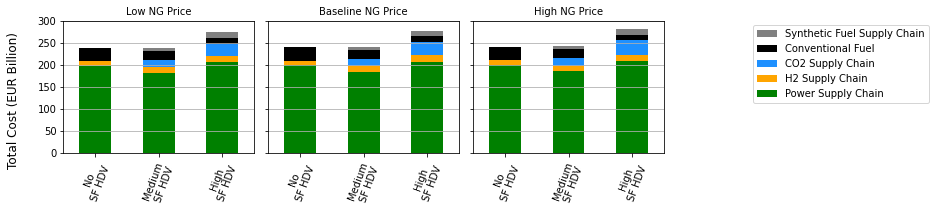

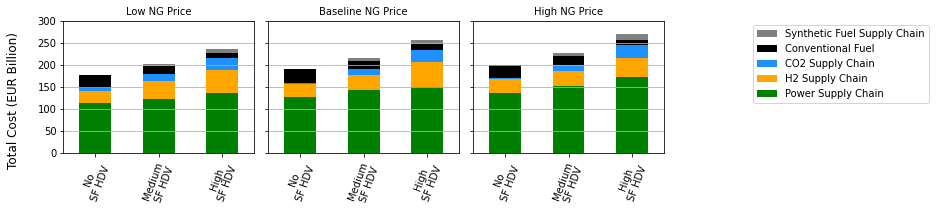

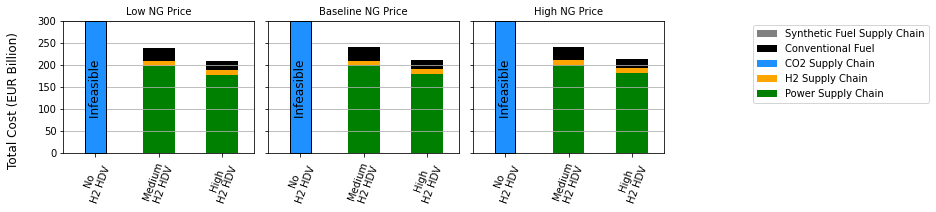

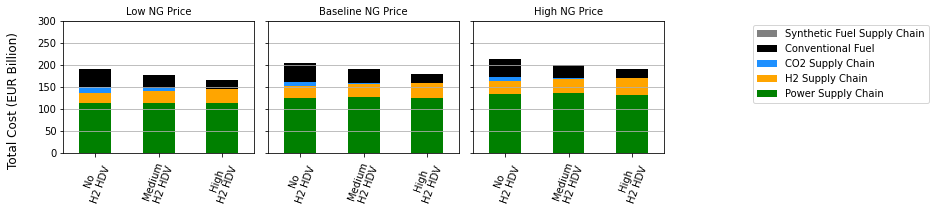

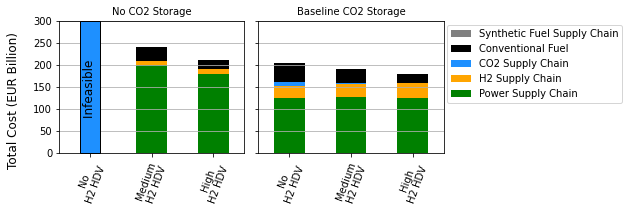

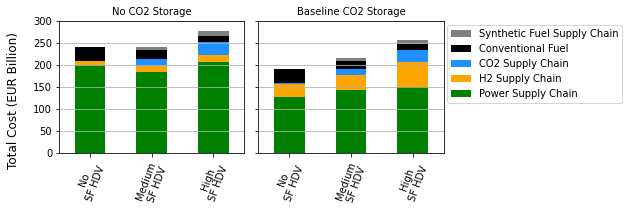

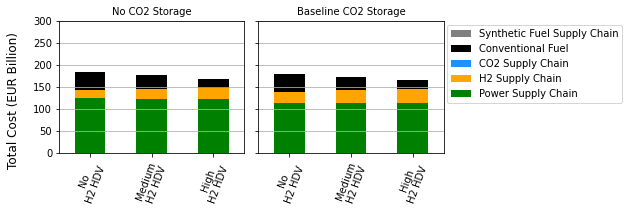

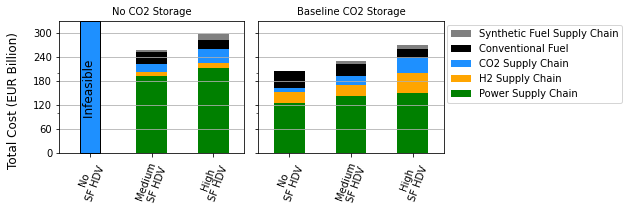

In [317]:
def plot_cost_ax(df, i, group_by, ax, dist_lower,dist_upper , group_col,
                 curr_mask, relative, stack_cols, subplot_titles,
                 ylim, plot_dist = True):
    
    # filter dataframe based on desired co2_percent
    filtered_df = df[df[group_col] == curr_mask].copy()
    
    if filtered_df.shape[0] < 3:
        # Create a new row of zeros
        new_row = pd.Series(0, index=filtered_df.columns)
        # Insert the new row as the first row
        filtered_df.loc[-1] = new_row
        filtered_df = filtered_df.iloc[np.arange(-1, len(filtered_df)-1)]
        
        ax.text(0, ylim[1]/2, "        Infeasible         ", fontsize=12, ha='center', va='center', bbox=dict(facecolor='dodgerblue'), rotation=90)

        
        

    if group_by == 'CO2':
        reference_row = filtered_df.iloc[0]
    else:
        reference_row = filtered_df[filtered_df['sf_percent'] == 0.0].iloc[0]
        
    # List of columns to normalize
    cost_columns = ['total_cost', 'Power', 'H2', 'CO2', 'ConvFuels', 'SynFuels']

    if relative: 
        # Normalize the columns by the reference scenario
        for col in cost_columns:
            filtered_df[col] = filtered_df[col] - reference_row[col]

    # plot stacked bar chart
    filtered_df[stack_cols].plot(kind='bar', stacked=True, ax=ax, color = ["green", "orange", "dodgerblue", "black", 'grey'], legend = False)

    if relative:
        if plot_dist == True:
            
            total_cost_lower = filtered_df["total_cost"] + dist_lower
            total_cost_upper= filtered_df["total_cost"] + dist_upper
            total_cost_avg = (total_cost_lower + total_cost_upper)/2
            cost_change_percent = total_cost_avg - total_cost_avg[0]
            error_bars = np.subtract(dist_upper, dist_lower)/2
        else:
            cost_change_percent = filtered_df["total_cost"] 
            
        
        # Create a new dataframe with these values
        df_values = pd.DataFrame(cost_change_percent, index=filtered_df.index)

        # Plot the new dataframe on the secondary y-axis
        df_values.plot(ax=ax, style='o', color = 'red', legend = False)

    
        if plot_dist == True:
            # add error bars for top stack
            top_stack = filtered_df['total_cost']
            ax.errorbar(x=filtered_df['total_cost'].index, y=cost_change_percent, yerr=error_bars, fmt='none', ecolor='red', capsize=5)

    if subplot_titles != None:
        # set x-axis label
        ax.set_title(subplot_titles, size = 10) 
        
    ax.grid(axis='y')
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    return ax

def plot_cost_dual(df_list,co2_percent_list, dist_lower, dist_upper, title, dir_name,xlabels,
                   subplot_titles,y_axis_label_list, relative = False,
                   save_name = 'baseline', group_by = 'CO2', ylim = [0,15], plot_dist = True):
    # extract columns for stacking
    stack_cols = ['Power', 'H2', 'CO2', 'ConvFuels','SynFuels']
    
    if group_by == 'CO2':
        group_col = 'co2_percent'
        y_axis_label = 'Total Cost (EUR Billion)'
    else:
         group_col = 'h2_percent'
         y_axis_label = 'Total Cost (EUR Billion)'
    
    # create subplots for each co2 percent
    fig, axes = plt.subplots(nrows=len(co2_percent_list), ncols=len(df_list), sharey=True, figsize=(3* len(df_list),3.2*len(co2_percent_list)))
    
    # loop through co2 percents and plot stacked bar chart on corresponding subplot
    for j, curr_df in enumerate(df_list):
        for i, curr_mask in enumerate(co2_percent_list):
            
            if len(co2_percent_list) != 1:
                curr_ax = axes[i,j]
            else:
                curr_ax = axes[j]
                
            
            if i == 0:
                curr_subplot_titles = subplot_titles[j]
            else:
                curr_subplot_titles = None
                
            
            curr_ax = plot_cost_ax(df = curr_df, 
                                i = i,
                                group_by = group_by,
                                ax = curr_ax,
                                dist_lower=dist_lower,
                                dist_upper=dist_upper,
                                group_col = group_col,
                                curr_mask=curr_mask, 
                                relative = relative, 
                                stack_cols = stack_cols,
                                subplot_titles = curr_subplot_titles,
                                ylim = ylim,
                                plot_dist = plot_dist
                                )
            
            if i == len(co2_percent_list) - 1 :
                curr_ax.set_xticklabels(xlabels, rotation=70)
                
            if j == 0:
                curr_ax.set_ylabel(y_axis_label_list[i])
        
    handles, labels = curr_ax.get_legend_handles_labels()
    
    
    fig.legend(handles[::-1], ['Power Supply Chain', 'H2 Supply Chain',
                         'CO2 Supply Chain', 'Conventional Fuel', 'Synthetic Fuel Supply Chain'][::-1],
               bbox_to_anchor= (1.4,0.85))


    
    # set main title
    fig.suptitle(title, fontsize=14)
     
    fig.text(-0.02, 0.5, y_axis_label, rotation="vertical", va="center", fontsize=12, ha = 'center')
    fig.tight_layout(rect=[0, 0, 1, 1])
    
    plt.savefig(dir_name + 'Figures/cost_' + save_name +'.png', dpi=300, bbox_inches='tight')
    
    # show plot
    plt.show()
    
    
plot_cost_dual(df_list = [ DATA_COST_sf_none_sen_ng_low, DATA_COST_sf_none, DATA_COST_sf_none_sen_ng_high],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
               subplot_titles =["Low NG Price", "Baseline NG Price","High NG Price"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name_sf_sen_ng,
                 relative = False, 
                 save_name =  'sf_hdv_sen_ng_none',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)



plot_cost_dual(df_list = [ DATA_COST_sf_baseline_sen_ng_low, DATA_COST_sf_baseline, DATA_COST_sf_baseline_sen_ng_high],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
               subplot_titles =["Low NG Price", "Baseline NG Price","High NG Price"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name_sf_sen_ng,
                 relative = False, 
                 save_name =  'sf_hdv_sen_ng_baseline',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)

plot_cost_dual(df_list = [ DATA_COST_none_sen_ng_low, DATA_COST_none, DATA_COST_none_sen_ng_high],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
               subplot_titles =["Low NG Price", "Baseline NG Price","High NG Price"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name_sen_ng_high,
                 relative = False, 
                 save_name =  'h2_hdv_sen_ng_none',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)

plot_cost_dual(df_list = [ DATA_COST_baseline_sen_ng_low, DATA_COST_baseline, DATA_COST_baseline_sen_ng_high],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
               subplot_titles =["Low NG Price", "Baseline NG Price","High NG Price"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name_sen_ng_high,
                 relative = False, 
                 save_name =  'h2_hdv_sen_ng_baseline',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)
    
plot_cost_dual(df_list = [ DATA_COST_none,DATA_COST_baseline],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
               subplot_titles =["No CO2 Storage", "Baseline CO2 Storage"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name,
                 relative = False, 
                 save_name =  'h2_HDV',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)
    
plot_cost_dual(df_list = [DATA_COST_sf_none,DATA_COST_sf_baseline],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
               subplot_titles =["No CO2 Storage", "Baseline CO2 Storage"],
               y_axis_label_list = [""],
                 title = '',
                 dir_name = directory_name_sf,
                 relative = False, 
                 save_name =  'SF_HDV',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)
    
plot_cost_dual(df_list = [DATA_COST_none_sen_relaxed,DATA_COST_baseline_sen_relaxed],
               co2_percent_list = [1.0],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
               subplot_titles =["No CO2 Storage", "Baseline CO2 Storage"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name_sen_relaxed,
                 relative = False, 
                 save_name =  'h2_hdv_relaxed',
                 group_by = "CO2",
                 ylim = [0,300],
              plot_dist = False)


plot_cost_dual(df_list = [DATA_COST_sf_none_sen_h2,DATA_COST_sf_baseline_sen_h2],
               co2_percent_list = [0.4],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
               xlabels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
               subplot_titles =["No CO2 Storage", "Baseline CO2 Storage"],
               y_axis_label_list = ["", ""],
                 title = '',
                 dir_name = directory_name_sf_sen_h2,
                 relative = False, 
                 save_name =  'sf_hdv_h2_sen',
                 group_by = "CO2",
                 ylim = [0,330],
              plot_dist = False)




In [291]:
def cost_diff_calc(df, co2_percent = None):
    if co2_percent != None:
        df = df[df["co2_percent"]== co2_percent]
    
    # Calculate the percentage difference with the previous row
    df['percent_diff_prev'] = df['total_cost'].pct_change() * 100

    # Calculate the percentage difference with the first row
    first_row_cost = df['total_cost'].iloc[0]
    df['percent_diff_first'] = ((df['total_cost'] - first_row_cost) / first_row_cost) * 100
    
    return df

cost_diff_calc(DATA_COST_baseline)
#cost_diff_calc(DATA_COST_baseline_sen_relaxed)

    

,scenario_name,co2_percent,h2_percent,sf_percent,total_cost,Power,H2,CO2,SynFuels,ConvFuels,percent_diff_prev,percent_diff_first
"0% H2, 40% CO2 Cap,\n Baseline CO2 Storage","0% H2, 40% CO2 Cap,\n Baseline CO2 Storage",0.4,0.0,0.0,203.288987,125.102066,26.630420,10.246344,0.0,41.310157,NaN,0.000000
"50% H2, 40% CO2 Cap,\n Baseline CO2 Storage","50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",0.4,0.5,0.0,190.325429,126.310200,30.715006,2.422216,0.0,30.878007,-6.376911,-6.376911
"100% H2, 40% CO2 Cap,\n Baseline CO2 Storage","100% H2, 40% CO2 Cap,\n Baseline CO2 Storage",0.4,1.0,0.0,178.921194,123.631452,34.799812,0.044073,0.0,20.445857,-5.991966,-11.986775


## Load Data

### Scenario Lists

In [178]:
scenario_name_dict_baseline = {
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_baseline_sf_0.0": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.0": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_0.4_co2stor_baseline_sf_0.0": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_none = {
                      #"Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_None_sf_0.0": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_None_sf_0.0": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_0.4_co2stor_None_sf_0.0": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_baseline_sen_ng_low = {
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_baseline_sf_0.0_ng_low": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.0_ng_low": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_0.4_co2stor_baseline_sf_0.0_ng_low": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_none_sen_ng_low = {
                      #"Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_None_sf_0.0": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_None_sf_0.0_ng_low": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_0.4_co2stor_None_sf_0.0_ng_low": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_baseline_sen_ng_high = {
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_baseline_sf_0.0_ng_high": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.0_ng_high": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_0.4_co2stor_baseline_sf_0.0_ng_high": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_none_sen_ng_high = {
                      #"Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_None_sf_0.0": "0% H2, 40% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_None_sf_0.0_ng_high": "50% H2, 40% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_0.4_co2stor_None_sf_0.0_ng_high": "100% H2, 40% CO2 Cap,\n Baseline CO2 Storage"
                      }


scenario_name_dict_sf_baseline = {
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.0_ng_medium": "50% H2, 40% CO2 Cap, 0% SF,\n Baseline CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.25_ng_medium": "50% H2, 40% CO2 Cap, 25% SF,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.5_ng_medium": "50% H2, 40% CO2 Cap, 50% SF,\n Baseline CO2 Storage"              
}

scenario_name_dict_sf_none = {
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.0_ng_medium": "50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.25_ng_medium": "50% H2, 40% CO2 Cap, 25% SF,\n No CO2 Storage",
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.5_ng_medium": "50% H2, 40% CO2 Cap, 50% SF,\n No CO2 Storage"
                    }

scenario_name_dict_sf_baseline_sen_ng_low = {
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.0_ng_low": "50% H2, 40% CO2 Cap, 0% SF,\n Baseline CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.25_ng_low": "50% H2, 40% CO2 Cap, 25% SF,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.5_ng_low": "50% H2, 40% CO2 Cap, 50% SF,\n Baseline CO2 Storage"              
}

scenario_name_dict_sf_none_sen_ng_low = {
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.0_ng_low": "50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.25_ng_low": "50% H2, 40% CO2 Cap, 25% SF,\n No CO2 Storage",
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.5_ng_low": "50% H2, 40% CO2 Cap, 50% SF,\n No CO2 Storage"
                    }

scenario_name_dict_sf_baseline_sen_ng_high = {
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.0_ng_high": "50% H2, 40% CO2 Cap, 0% SF,\n Baseline CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.25_ng_high": "50% H2, 40% CO2 Cap, 25% SF,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_baseline_sf_0.5_ng_high": "50% H2, 40% CO2 Cap, 50% SF,\n Baseline CO2 Storage"              
}

scenario_name_dict_sf_none_sen_ng_high = {
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.0_ng_high": "50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.25_ng_high": "50% H2, 40% CO2 Cap, 25% SF,\n No CO2 Storage",
                      "Dec_29_2040_Base_h2_0.5_co2_0.4_co2stor_none_sf_0.5_ng_high": "50% H2, 40% CO2 Cap, 50% SF,\n No CO2 Storage"
                    }


scenario_name_dict_baseline_sen_relaxed = {
                      "Dec_29_2040_Base_h2_0.0_co2_1.0_co2stor_baseline_sf_0.0": "0% H2, 100% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_1.0_co2stor_baseline_sf_0.0": "50% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_1.0_co2stor_baseline_sf_0.0": "100% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }

scenario_name_dict_none_sen_relaxed = {
                      "Dec_29_2040_Base_h2_0.0_co2_1.0_co2stor_None_sf_0.0": "0% H2, 100% CO2 Cap,\n Baseline CO2 Storage", 
                      "Dec_29_2040_Base_h2_0.5_co2_1.0_co2stor_None_sf_0.0": "50% H2, 100% CO2 Cap,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_1.0_co2_1.0_co2stor_None_sf_0.0": "100% H2, 100% CO2 Cap,\n Baseline CO2 Storage"
                      }


scenario_name_dict_sf_baseline_sen_h2 = {
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_baseline_sf_0.0_ng_medium": "0% H2, 40% CO2 Cap, 0% SF,\n Baseline CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_baseline_sf_0.177_ng_medium": "0% H2, 40% CO2 Cap, 25% SF,\n Baseline CO2 Storage",
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_baseline_sf_0.354_ng_medium": "0% H2, 40% CO2 Cap, 50% SF,\n Baseline CO2 Storage"              
}

scenario_name_dict_sf_none_sen_h2 = {
                      #"Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_none_sf_0.0_ng_medium": "0% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",               
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_none_sf_0.177_ng_medium": "0% H2, 40% CO2 Cap, 25% SF,\n No CO2 Storage",
                      "Dec_29_2040_Base_h2_0.0_co2_0.4_co2stor_none_sf_0.354_ng_medium": "0% H2, 40% CO2 Cap, 50% SF,\n No CO2 Storage"
                    }




s1_scenario_list_baseline = list(scenario_name_dict_baseline.keys())
s1_scenario_list_baseline_vals = list(scenario_name_dict_baseline.values())
s1_scenario_list_none = list(scenario_name_dict_none.keys())
s1_scenario_list_none_vals = list(scenario_name_dict_none.values())

s1_scenario_list_baseline_sen_ng_low = list(scenario_name_dict_baseline_sen_ng_low.keys())
s1_scenario_list_baseline_sen_ng_low_vals = list(scenario_name_dict_baseline_sen_ng_low.values())
s1_scenario_list_none_sen_ng_low = list(scenario_name_dict_none_sen_ng_low.keys())
s1_scenario_list_none_sen_ng_low_vals = list(scenario_name_dict_none_sen_ng_low.values())

s1_scenario_list_baseline_sen_ng_high = list(scenario_name_dict_baseline_sen_ng_high.keys())
s1_scenario_list_baseline_sen_ng_high_vals = list(scenario_name_dict_baseline_sen_ng_high.values())
s1_scenario_list_none_sen_ng_high = list(scenario_name_dict_none_sen_ng_high.keys())
s1_scenario_list_none_sen_ng_high_vals = list(scenario_name_dict_none_sen_ng_high.values())

s1_scenario_list_sf_baseline = list(scenario_name_dict_sf_baseline.keys())
s1_scenario_list_sf_baseline_vals = list(scenario_name_dict_sf_baseline.values())
s1_scenario_list_sf_none = list(scenario_name_dict_sf_none.keys())
s1_scenario_list_sf_none_vals = list(scenario_name_dict_sf_none.values())

s1_scenario_list_sf_baseline_sen_ng_low = list(scenario_name_dict_sf_baseline_sen_ng_low.keys())
s1_scenario_list_sf_baseline_sen_ng_low_vals = list(scenario_name_dict_sf_baseline_sen_ng_low.values())
s1_scenario_list_sf_none_sen_ng_low = list(scenario_name_dict_sf_none_sen_ng_low.keys())
s1_scenario_list_sf_none_sen_ng_low_vals = list(scenario_name_dict_sf_none_sen_ng_low.values())

s1_scenario_list_sf_baseline_sen_ng_high = list(scenario_name_dict_sf_baseline_sen_ng_high.keys())
s1_scenario_list_sf_baseline_sen_ng_high_vals = list(scenario_name_dict_sf_baseline_sen_ng_high.values())
s1_scenario_list_sf_none_sen_ng_high = list(scenario_name_dict_sf_none_sen_ng_high.keys())
s1_scenario_list_sf_none_sen_ng_high_vals = list(scenario_name_dict_sf_none_sen_ng_high.values())


s1_scenario_list_baseline_sen_relaxed = list(scenario_name_dict_baseline_sen_relaxed.keys())
s1_scenario_list_baseline_sen_relaxed_vals = list(scenario_name_dict_baseline_sen_relaxed.values())
s1_scenario_list_none_sen_relaxed = list(scenario_name_dict_none_sen_relaxed.keys())
s1_scenario_list_none_sen_relaxed_vals = list(scenario_name_dict_none_sen_relaxed.values())

s1_scenario_list_sf_baseline_sen_h2 = list(scenario_name_dict_sf_baseline_sen_h2.keys())
s1_scenario_list_sf_baseline_sen_h2_vals = list(scenario_name_dict_sf_baseline_sen_h2.values())
s1_scenario_list_sf_none_sen_h2 = list(scenario_name_dict_sf_none_sen_h2.keys())
s1_scenario_list_sf_none_sen_h2_vals = list(scenario_name_dict_sf_none_sen_h2.values())



### Load data for H2 Scenarios


In [30]:
directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_1_v1/"

DATA_POWER_baseline = read_power_data(s1_scenario_list_baseline, scenario_name_dict_baseline,directory_name)
DATA_COST_baseline = read_cost_data(s1_scenario_list_baseline,scenario_name_dict_baseline, directory_name)
DATA_EMISSIONS_baseline = read_emission_data(s1_scenario_list_baseline, scenario_name_dict_baseline, directory_name)
DATA_H2_baseline = read_h2_data(s1_scenario_list_baseline, scenario_name_dict_baseline, directory_name)
DATA_FUEL_baseline = read_fossil_fuel_data(s1_scenario_list_baseline, scenario_name_dict_baseline,directory_name).drop(columns = ["index", "sector"])

<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h2_storage_capacity_df["Resource"] = "Storage"


In [33]:
directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_1_v1/"

DATA_POWER_none = read_power_data(s1_scenario_list_none, scenario_name_dict_none,directory_name)
DATA_COST_none = read_cost_data(s1_scenario_list_none,scenario_name_dict_none, directory_name)
DATA_EMISSIONS_none = read_emission_data(s1_scenario_list_none, scenario_name_dict_none, directory_name)
DATA_H2_none = read_h2_data(s1_scenario_list_none, scenario_name_dict_none, directory_name)
DATA_FUEL_none = read_fossil_fuel_data(s1_scenario_list_none, scenario_name_dict_none,directory_name).drop(columns = ["index", "sector"])


<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h2_storage_capacity_df["Resource"] = "Storage"


### Load Data H2 Emissions Sensitivity

In [124]:
directory_name_sen_relaxed =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_1_v1_sen_emissions/"

DATA_POWER_none_sen_relaxed = read_power_data(s1_scenario_list_none_sen_relaxed, scenario_name_dict_none_sen_relaxed,directory_name_sen_relaxed)
DATA_COST_none_sen_relaxed = read_cost_data(s1_scenario_list_none_sen_relaxed,scenario_name_dict_none_sen_relaxed, directory_name_sen_relaxed)
DATA_EMISSIONS_none_sen_relaxed = read_emission_data(s1_scenario_list_none_sen_relaxed, scenario_name_dict_none_sen_relaxed, directory_name_sen_relaxed)
DATA_H2_none_sen_relaxed = read_h2_data(s1_scenario_list_none_sen_relaxed, scenario_name_dict_none_sen_relaxed, directory_name_sen_relaxed)
DATA_FUEL_none_sen_relaxed = read_fossil_fuel_data(s1_scenario_list_none_sen_relaxed, scenario_name_dict_none_sen_relaxed,directory_name_sen_relaxed).drop(columns = ["index", "sector"])

DATA_POWER_baseline_sen_relaxed = read_power_data(s1_scenario_list_baseline_sen_relaxed, scenario_name_dict_baseline_sen_relaxed,directory_name_sen_relaxed)
DATA_COST_baseline_sen_relaxed = read_cost_data(s1_scenario_list_baseline_sen_relaxed,scenario_name_dict_baseline_sen_relaxed, directory_name_sen_relaxed)
DATA_EMISSIONS_baseline_sen_relaxed = read_emission_data(s1_scenario_list_baseline_sen_relaxed, scenario_name_dict_baseline_sen_relaxed, directory_name_sen_relaxed)
DATA_H2_baseline_sen_relaxed = read_h2_data(s1_scenario_list_baseline_sen_relaxed, scenario_name_dict_baseline_sen_relaxed, directory_name_sen_relaxed)
DATA_FUEL_baseline_sen_relaxed = read_fossil_fuel_data(s1_scenario_list_baseline_sen_relaxed, scenario_name_dict_baseline_sen_relaxed,directory_name_sen_relaxed).drop(columns = ["index", "sector"])


<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h2_storage_capacity_df["Resource"] = "Storage"


### Load Data H2 NG Sensitivity

In [203]:
directory_name_sen_ng_low =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_1_v1_sen_ng_price/"

DATA_POWER_baseline_sen_ng_low = read_power_data(s1_scenario_list_baseline_sen_ng_low, scenario_name_dict_baseline_sen_ng_low,directory_name_sen_ng_low)
DATA_COST_baseline_sen_ng_low = read_cost_data(s1_scenario_list_baseline_sen_ng_low,scenario_name_dict_baseline_sen_ng_low, directory_name_sen_ng_low)
DATA_EMISSIONS_baseline_sen_ng_low = read_emission_data(s1_scenario_list_baseline_sen_ng_low, scenario_name_dict_baseline_sen_ng_low, directory_name_sen_ng_low)
DATA_H2_baseline_sen_ng_low = read_h2_data(s1_scenario_list_baseline_sen_ng_low, scenario_name_dict_baseline_sen_ng_low, directory_name_sen_ng_low)
DATA_FUEL_baseline_sen_ng_low = read_fossil_fuel_data(s1_scenario_list_baseline_sen_ng_low, scenario_name_dict_baseline_sen_ng_low,directory_name_sen_ng_low).drop(columns = ["index", "sector"])



DATA_POWER_none_sen_ng_low = read_power_data(s1_scenario_list_none_sen_ng_low, scenario_name_dict_none_sen_ng_low,directory_name_sen_ng_low)
DATA_COST_none_sen_ng_low = read_cost_data(s1_scenario_list_none_sen_ng_low,scenario_name_dict_none_sen_ng_low, directory_name_sen_ng_low)
DATA_EMISSIONS_none_sen_ng_low = read_emission_data(s1_scenario_list_none_sen_ng_low, scenario_name_dict_none_sen_ng_low, directory_name_sen_ng_low)
DATA_H2_none_sen_ng_low = read_h2_data(s1_scenario_list_none_sen_ng_low, scenario_name_dict_none_sen_ng_low, directory_name_sen_ng_low)
DATA_FUEL_none_sen_ng_low = read_fossil_fuel_data(s1_scenario_list_none_sen_ng_low, scenario_name_dict_none_sen_ng_low,directory_name_sen_ng_low).drop(columns = ["index", "sector"])

directory_name_sen_ng_high =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_1_v1_sen_ng_price/"

DATA_POWER_baseline_sen_ng_high = read_power_data(s1_scenario_list_baseline_sen_ng_high, scenario_name_dict_baseline_sen_ng_high,directory_name_sen_ng_high)
DATA_COST_baseline_sen_ng_high = read_cost_data(s1_scenario_list_baseline_sen_ng_high,scenario_name_dict_baseline_sen_ng_high, directory_name_sen_ng_high)
DATA_EMISSIONS_baseline_sen_ng_high = read_emission_data(s1_scenario_list_baseline_sen_ng_high, scenario_name_dict_baseline_sen_ng_high, directory_name_sen_ng_high)
DATA_H2_baseline_sen_ng_high = read_h2_data(s1_scenario_list_baseline_sen_ng_high, scenario_name_dict_baseline_sen_ng_high, directory_name_sen_ng_high)
DATA_FUEL_baseline_sen_ng_high = read_fossil_fuel_data(s1_scenario_list_baseline_sen_ng_high, scenario_name_dict_baseline_sen_ng_high,directory_name_sen_ng_high).drop(columns = ["index", "sector"])



DATA_POWER_none_sen_ng_high = read_power_data(s1_scenario_list_none_sen_ng_high, scenario_name_dict_none_sen_ng_high,directory_name_sen_ng_high)
DATA_COST_none_sen_ng_high = read_cost_data(s1_scenario_list_none_sen_ng_high,scenario_name_dict_none_sen_ng_high, directory_name_sen_ng_high)
DATA_EMISSIONS_none_sen_ng_high = read_emission_data(s1_scenario_list_none_sen_ng_high, scenario_name_dict_none_sen_ng_high, directory_name_sen_ng_high)
DATA_H2_none_sen_ng_high = read_h2_data(s1_scenario_list_none_sen_ng_high, scenario_name_dict_none_sen_ng_high, directory_name_sen_ng_high)
DATA_FUEL_none_sen_ng_high = read_fossil_fuel_data(s1_scenario_list_none_sen_ng_high, scenario_name_dict_none_sen_ng_high,directory_name_sen_ng_high).drop(columns = ["index", "sector"])



/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

### Load data for SF Scenarios

In [106]:
directory_name_sf =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_2_v1/"

DATA_POWER_sf_baseline = read_power_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline,directory_name_sf)
DATA_COST_sf_baseline = read_cost_data(s1_scenario_list_sf_baseline,scenario_name_dict_sf_baseline, directory_name_sf)
DATA_EMISSIONS_sf_baseline = read_emission_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline, directory_name_sf)
DATA_H2_sf_baseline = read_h2_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline, directory_name_sf)
DATA_FUEL_sf_baseline = read_fossil_fuel_data(s1_scenario_list_sf_baseline, scenario_name_dict_sf_baseline,directory_name_sf).drop(columns = ["index", "sector"])

DATA_POWER_sf_none = read_power_data(s1_scenario_list_sf_none, scenario_name_dict_sf,directory_name_sf)
DATA_COST_sf_none = read_cost_data(s1_scenario_list_sf_none,scenario_name_dict_sf_none, directory_name_sf)
DATA_EMISSIONS_sf_none = read_emission_data(s1_scenario_list_sf_none, scenario_name_dict_sf_none, directory_name_sf)
DATA_H2_sf_none = read_h2_data(s1_scenario_list_sf_none, scenario_name_dict_sf_none, directory_name_sf)
DATA_FUEL_sf_none = read_fossil_fuel_data(s1_scenario_list_sf_none, scenario_name_dict_sf_none,directory_name_sf).drop(columns = ["index", "sector"])

/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/youssefshaker/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

### Load Data SF H2 Sen

In [142]:
directory_name_sf_sen_h2 =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_2_v1_sen_h2/"

DATA_POWER_sf_baseline_sen_h2 = read_power_data(s1_scenario_list_sf_baseline_sen_h2, scenario_name_dict_sf_baseline_sen_h2,directory_name_sf_sen_h2)
DATA_COST_sf_baseline_sen_h2 = read_cost_data(s1_scenario_list_sf_baseline_sen_h2,scenario_name_dict_sf_baseline_sen_h2, directory_name_sf_sen_h2)
DATA_EMISSIONS_sf_baseline_sen_h2 = read_emission_data(s1_scenario_list_sf_baseline_sen_h2, scenario_name_dict_sf_baseline_sen_h2, directory_name_sf_sen_h2)
DATA_H2_sf_baseline_sen_h2 = read_h2_data(s1_scenario_list_sf_baseline_sen_h2, scenario_name_dict_sf_baseline_sen_h2, directory_name_sf_sen_h2)
DATA_FUEL_sf_baseline_sen_h2 = read_fossil_fuel_data(s1_scenario_list_sf_baseline_sen_h2, scenario_name_dict_sf_baseline_sen_h2,directory_name_sf_sen_h2).drop(columns = ["index", "sector"])

DATA_POWER_sf_none_sen_h2 = read_power_data(s1_scenario_list_sf_none_sen_h2, scenario_name_dict_sf_none_sen_h2,directory_name_sf_sen_h2)
DATA_COST_sf_none_sen_h2 = read_cost_data(s1_scenario_list_sf_none_sen_h2,scenario_name_dict_sf_none_sen_h2, directory_name_sf_sen_h2)
DATA_EMISSIONS_sf_none_sen_h2 = read_emission_data(s1_scenario_list_sf_none_sen_h2, scenario_name_dict_sf_none_sen_h2, directory_name_sf_sen_h2)
DATA_H2_sf_none_sen_h2 = read_h2_data(s1_scenario_list_sf_none_sen_h2, scenario_name_dict_sf_none_sen_h2, directory_name_sf_sen_h2)
DATA_FUEL_sf_none_sen_h2 = read_fossil_fuel_data(s1_scenario_list_sf_none_sen_h2, scenario_name_dict_sf_none_sen_h2,directory_name_sf_sen_h2).drop(columns = ["index", "sector"])

<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h2_storage_capacity_df["Resource"] = "Storage"


### Load Data SF NG Sen

In [182]:
directory_name_sf_sen_ng =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Dec_29_core_set_2_v1_sen_ng_price/"

DATA_POWER_sf_baseline_sen_ng_low = read_power_data(s1_scenario_list_sf_baseline_sen_ng_low, scenario_name_dict_sf_baseline_sen_ng_low,directory_name_sf_sen_ng)
DATA_COST_sf_baseline_sen_ng_low = read_cost_data(s1_scenario_list_sf_baseline_sen_ng_low,scenario_name_dict_sf_baseline_sen_ng_low, directory_name_sf_sen_ng)
DATA_EMISSIONS_sf_baseline_sen_ng_low = read_emission_data(s1_scenario_list_sf_baseline_sen_ng_low, scenario_name_dict_sf_baseline_sen_ng_low, directory_name_sf_sen_ng)
DATA_H2_sf_baseline_sen_ng_low = read_h2_data(s1_scenario_list_sf_baseline_sen_ng_low, scenario_name_dict_sf_baseline_sen_ng_low, directory_name_sf_sen_ng)
DATA_FUEL_sf_baseline_sen_ng_low = read_fossil_fuel_data(s1_scenario_list_sf_baseline_sen_ng_low, scenario_name_dict_sf_baseline_sen_ng_low,directory_name_sf_sen_ng).drop(columns = ["index", "sector"])

DATA_POWER_sf_none_sen_ng_low = read_power_data(s1_scenario_list_sf_none_sen_ng_low, scenario_name_dict_sf_none_sen_ng_low,directory_name_sf_sen_ng)
DATA_COST_sf_none_sen_ng_low = read_cost_data(s1_scenario_list_sf_none_sen_ng_low,scenario_name_dict_sf_none_sen_ng_low, directory_name_sf_sen_ng)
DATA_EMISSIONS_sf_none_sen_ng_low = read_emission_data(s1_scenario_list_sf_none_sen_ng_low, scenario_name_dict_sf_none_sen_ng_low, directory_name_sf_sen_ng)
DATA_H2_sf_none_sen_ng_low = read_h2_data(s1_scenario_list_sf_none_sen_ng_low, scenario_name_dict_sf_none_sen_ng_low, directory_name_sf_sen_ng)
DATA_FUEL_sf_none_sen_ng_low = read_fossil_fuel_data(s1_scenario_list_sf_none_sen_ng_low, scenario_name_dict_sf_none_sen_ng_low,directory_name_sf_sen_ng).drop(columns = ["index", "sector"])


DATA_POWER_sf_baseline_sen_ng_high = read_power_data(s1_scenario_list_sf_baseline_sen_ng_high, scenario_name_dict_sf_baseline_sen_ng_high,directory_name_sf_sen_ng)
DATA_COST_sf_baseline_sen_ng_high = read_cost_data(s1_scenario_list_sf_baseline_sen_ng_high,scenario_name_dict_sf_baseline_sen_ng_high, directory_name_sf_sen_ng)
DATA_EMISSIONS_sf_baseline_sen_ng_high = read_emission_data(s1_scenario_list_sf_baseline_sen_ng_high, scenario_name_dict_sf_baseline_sen_ng_high, directory_name_sf_sen_ng)
DATA_H2_sf_baseline_sen_ng_high = read_h2_data(s1_scenario_list_sf_baseline_sen_ng_high, scenario_name_dict_sf_baseline_sen_ng_high, directory_name_sf_sen_ng)
DATA_FUEL_sf_baseline_sen_ng_high = read_fossil_fuel_data(s1_scenario_list_sf_baseline_sen_ng_high, scenario_name_dict_sf_baseline_sen_ng_high,directory_name_sf_sen_ng).drop(columns = ["index", "sector"])

DATA_POWER_sf_none_sen_ng_high = read_power_data(s1_scenario_list_sf_none_sen_ng_high, scenario_name_dict_sf_none_sen_ng_high,directory_name_sf_sen_ng)
DATA_COST_sf_none_sen_ng_high = read_cost_data(s1_scenario_list_sf_none_sen_ng_high,scenario_name_dict_sf_none_sen_ng_high, directory_name_sf_sen_ng)
DATA_EMISSIONS_sf_none_sen_ng_high = read_emission_data(s1_scenario_list_sf_none_sen_ng_high, scenario_name_dict_sf_none_sen_ng_high, directory_name_sf_sen_ng)
DATA_H2_sf_none_sen_ng_high = read_h2_data(s1_scenario_list_sf_none_sen_ng_high, scenario_name_dict_sf_none_sen_ng_high, directory_name_sf_sen_ng)
DATA_FUEL_sf_none_sen_ng_high = read_fossil_fuel_data(s1_scenario_list_sf_none_sen_ng_high, scenario_name_dict_sf_none_sen_ng_high,directory_name_sf_sen_ng).drop(columns = ["index", "sector"])

<ipython-input-11-ed36b0b3b96b>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h2_storage_capacity_df["Resource"] = "Storage"


### Extras

In [ ]:
directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v5/"

DATA_EMISSIONS_baseline_new = read_emission_data(s1_scenario_list_baseline_new, scenario_name_dict_baseline_new, directory_name)

directory_name_no_co2 =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v5_no_co2/"

DATA_EMISSIONS_none = read_emission_data(s1_scenario_list_none, scenario_name_dict_none, directory_name_no_co2)


In [ ]:
DATA_EMISSIONS_baseline_new[0]

In [ ]:
battery_df = pd.DataFrame()

for i, curr_df in enumerate(DATA_POWER_sf_baseline[1]):
    
    curr_row = curr_df.query('resource_type == "Battery"')
    
  
    battery_df = pd.concat([battery_df, curr_row])
    
battery_df

In [ ]:
def create_fuels_df(fuel_df, storage_sen):
    def fuel_label(Fuel):
        if "_ng" in Fuel:
            return "ng"
        elif ("Trans" in Fuel) and ("Syn" not in Fuel):
            return "LF"
        else:
            return "neither"
        
    fuel_df["storage_sen"] = storage_sen
    fuel_df["fuel_label"] = list(map(fuel_label,fuel_df.Fuel))
    df_new = fuel_df.groupby(["fuel_label", "co2_percent", "h2_percent", "sf_percent","storage_sen"]).sum()
    df_new = df_new[(df_new.index.get_level_values("co2_percent") == 0.4) & (df_new.index.get_level_values("fuel_label") != "neither")]
    df_new["fuel_cons"] = df_new["fuel_cons"]* 2.93071e-7
    
    return df_new


In [ ]:
def plot_fuels_comp_panel(fuels_df_list, ax, show_legend = False, show_y_label = False, title = None):
    df = pd.concat(fuels_df_list).reset_index()
    
    # Filter the DataFrame for "LF" and "ng" fuel labels
    lf_data = df[df['fuel_label'] == 'LF']
    ng_data = df[df['fuel_label'] == 'ng']
    
    # Define marker styles for different values of "storage_sen"
    marker_styles = {'Baseline': 'o', 'None': '^'}

    marker_size = 70
    ax.set_aspect('equal')

    # Create a scatter plot with different marker styles based on "storage_sen"
    for storage_sen, marker in marker_styles.items():
        lf_subset = lf_data[lf_data['storage_sen'] == storage_sen]
        ng_subset = ng_data[ng_data['storage_sen'] == storage_sen]

        ax.scatter(lf_subset['fuel_cons'], ng_subset['fuel_cons'], marker=marker, s=marker_size, label=f'CO2 Storage:\n{storage_sen}')

        ax.plot(lf_subset['fuel_cons'], ng_subset['fuel_cons'], linestyle='-', marker='')

    # Add labels and title
    ax.set_xlabel('Liquid Fuel Consumption (TWh)', size=10)
    
    if show_y_label:
        ax.set_ylabel('Natural Gas Consumption (TWh)', size=10)
        
    ax.set_title(title)
    ax.set_xlim(0, 600)

    if show_legend:
        # Add a legend
        ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
        
    return ax


def plot_fuels_comp(fuels_df_lists, titles, dir_name):
    # Create a list of fuels_df_lists

    # Create subplots for each fuels_df_list
    num_subplots = len(fuels_df_lists)

    num_cols = num_subplots

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_cols, figsize=(3.5 * num_cols, 6), sharey = True)

    # Loop through each fuels_df_list and create a subplot for each
    for i, fuels_df_list in enumerate(fuels_df_lists):
        if num_subplots > 1:
            ax = axes[i]
        else:
            ax = axes  # If there's only one subplot, ax is the single axis
            
        show_legend = i == len(fuels_df_lists) - 1
        show_y_label = i == 0
        # Call the plot_fuels_comp function with the specific fuels_df_list
        plot_fuels_comp_panel(fuels_df_list, ax, show_legend, show_y_label, titles[i])

    # Adjust spacing between subplots if needed
    plt.tight_layout()
    
    plt.savefig(dir_name + 'Figures/fuel_comparison.png', dpi=300, bbox_inches='tight')
    

    # Show the plot
    plt.show()
    
df_fuel_comp_baseline = create_fuels_df(DATA_FUEL_baseline_new, "Baseline")
df_fuel_comp_none = create_fuels_df(DATA_FUEL_none, "None")
df_fuel_comp_baseline_sf = create_fuels_df(DATA_FUEL_sf_baseline, "Baseline")
df_fuel_comp_none_sf = create_fuels_df(DATA_FUEL_sf_none, "None")
    
fuels_df_lists = [[df_fuel_comp_baseline, df_fuel_comp_none], [df_fuel_comp_baseline_sf, df_fuel_comp_none_sf]] 
titles = ["H2 HDV Scenarios", "SF HDV Scenarios"]

plot_fuels_comp(fuels_df_lists, titles, directory_name)


DATA_FUEL_sf_baseline

In [ ]:
DATA_EMISSIONS_sf_baseline[0].to_csv("emissions_sf_new.csv")

In [ ]:

directory_name =  "/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v4/"
DATA_EMISSIONS_none_sf_fp_low = read_emission_data(s1_scenario_list_none_sf_fp_low, scenario_name_dict_none_sf_fp_low, directory_name_fp)


In [ ]:
long_lat_df = pd.read_csv("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Pypsa Networks/Out 2/buses.csv")[["name","x","y"]]
long_lat_df["name"] = long_lat_df["name"].str[0:3]

def process_power_flows(dir_name):
    
    # Read data
    trans_map = pd.read_csv(dir_name + "/Network.csv")
    flows_df = pd.read_csv(dir_name + "/Results/flow.csv").iloc[0,:]

    # Create country map dictionary
    country_map_dict = trans_map.iloc[:,0:2]
    country_map_dict = country_map_dict[~country_map_dict.iloc[:,0].isna()]
    country_map_dict.columns = ["country", "zones"]
    country_map_dict["country"] = country_map_dict["country"].str[0:3]
    country_map_dict = dict(zip(country_map_dict["zones"], country_map_dict["country"]))

    # Process lines
    lines = trans_map.iloc[:,2:13].melt(id_vars = "Network_Lines", var_name = "zone", value_name = "dir")
    lines = lines.query('dir != 0').pivot(index = "Network_Lines", columns = "dir", values = "zone").reset_index()
    lines.columns = ["lines", "zone_neg", "zone_pos"]

    lines["flow"] = flows_df.reset_index().iloc[1:-1,1].reset_index(drop = True)

    # Create new line flow data frame
    new_line_flow_df = pd.DataFrame(columns = ["line", "zone_in", "zone_out", "flow"])
    

    for _, row in lines.iterrows():
        zone_in, zone_out, flow = row["zone_neg"], row["zone_pos"], row["flow"]

        if float(zone_out[1:]) < float(zone_in[1:]):
            zone_in, zone_out = zone_out, zone_in
            flow *= -1

        new_line_flow_df.loc[len(new_line_flow_df)] = [row["lines"], zone_in, zone_out, flow]
    # Group and reset index
    line_flow_summarized_df = new_line_flow_df.groupby(["zone_in", "zone_out"]).sum().reset_index()
    

    # Process flows
    line_flow_summarized_pos_df = pd.DataFrame(columns = ["zone_in", "zone_out", "flow"])

    for _, row in line_flow_summarized_df.iterrows():
        zone_in, zone_out, flow = row["zone_in"], row["zone_out"], row["flow"]

        if flow < 0:
            zone_in, zone_out = zone_out, zone_in
            flow *= -1

        line_flow_summarized_pos_df.loc[len(line_flow_summarized_pos_df)] = [zone_in, zone_out, flow*10e-6]

    # Filter out zero flows and map zones to countries
    line_flow_summarized_pos_df = line_flow_summarized_pos_df.query('flow != 0')
    line_flow_summarized_pos_df = line_flow_summarized_pos_df.replace({"zone_in" : country_map_dict, "zone_out" : country_map_dict})

    return line_flow_summarized_pos_df

def draw_network(line_flow_summarized_pos_df, bubbles_df, long_lat_df, ax, title="", max_val=500, show_colorbar=False):
    G = nx.DiGraph()

    # Generate edge list and corresponding weights
    elist = [(row[1][0], row[1][1]) for row in line_flow_summarized_pos_df.iterrows()]
    eweight = [row[1][2] for row in line_flow_summarized_pos_df.iterrows()]

    # Add edges to the graph
    G.add_edges_from(elist)

    # Initialize basemap
    m = Basemap(projection='merc',
                llcrnrlon=-10,
                llcrnrlat=45,
                urcrnrlon=20,
                urcrnrlat=63,
                lat_ts=0,
                resolution='i',
                suppress_ticks=True,
                ax=ax)  # Set the axes to ax

    # Draw the basemap (geographical features)
    m.drawcoastlines()
    m.fillcontinents(color='whitesmoke', lake_color='white')
    m.drawmapboundary(fill_color='white')
    m.drawcountries()

    # Create node positions
    pos = {node: m(long_lat_df.loc[long_lat_df["name"] == node, "x"].values[0],
                   long_lat_df.loc[long_lat_df["name"] == node, "y"].values[0])
           for node in G.nodes()}

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color="lightcoral", node_size=400, ax = ax)
    nx.draw_networkx_labels(G, pos, ax = ax)

    # Edge widths and colors
    min_width = 0
    max_width = 6
    #edge_widths = [(w / max_val) * (max_width - min_width) + min_width for w in eweight]
    edge_widths = 2
    sm = ScalarMappable(cmap='winter', norm=Normalize(vmin=0, vmax=max_val))
    #edge_colors = sm.to_rgba(eweight)
    edge_colors = sm.to_rgba(3)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=elist, edge_color=edge_colors, width=edge_widths, arrows=False, ax = ax)
    #nx.draw_networkx_edges(G, pos, edgelist=elist, edge_color=edge_colors, width=edge_widths, arrows=True, ax = ax)
    
    wind_onshore_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Wind - Onshore'")
    wind_offshore_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Wind - Offshore'")
    #gas_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Gas'")
    #gas_w_ccs_df = bubbles_df.merge(long_lat_df, left_on = ["zone"], right_on = ["name"], how = "left").query("resource_type == 'Gas w/ CCS'")
    
    gen_list = [wind_onshore_df, wind_offshore_df]#, gas_df, gas_w_ccs_df]
    bubble_colors = ["green", "blue", "red", "purple"]
    
    # Plot bubbles
    for i, curr_gen_df in enumerate(gen_list):
        for _, row in curr_gen_df.iterrows():
            x, y = m(row["x"], row["y"])
            bubble_size = row["generation_twh"]*250
            ax.scatter(x, y, s=bubble_size, c=bubble_colors[i], alpha=0.3, edgecolors = 'black')
        

    # Remove axis and add colorbar and title
    ax.axis('off')
    if show_colorbar:
        fig = ax.figure  # get the figure of the ax
        fig.colorbar(sm, ax=ax)
    
    ax.set_title(title)

    
def plot_power_flows(root_dir, scenario_names, generation_data_list, long_lat_df, scenario_name_dict_all, sector = "power", max_val = 500):
    # Set the number of subplots
    n = len(scenario_names)
    
    # Initialize the figure and subplots
    fig, axs = plt.subplots(1, n, figsize=(n * 8, 8))  # Width and height in inches

    for i, curr_scenario_name in enumerate(scenario_names):

        curr_scenario_dir = root_dir+curr_scenario_name
        
        if sector == "power":
            # Process power flows
            line_flow_summarized_pos_df = process_power_flows(curr_scenario_dir)
        elif sector == "h2":
            # Process h2 flows
            line_flow_summarized_pos_df = process_h2_flows(curr_scenario_dir)

        
        # Set a title for the plot
        title = ""
        
        # Set the maximum value for the flow normalization
        max_val = 1500
        
        bubbles_df = pd.concat(generation_data_list).query("scenario == @title")
        
        if n == 1:
            curr_axs = axs
        else:
            curr_axs = axs[i]
    
        # Draw the network
        draw_network(line_flow_summarized_pos_df, bubbles_df, long_lat_df, curr_axs, title, max_val, False)

    # Display the plots
    plt.tight_layout()
    plt.show()

    fig.savefig(root_dir + 'Figures/network.png' , dpi=300, bbox_inches='tight')
    
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

plot_power_flows("/Users/youssefshaker/Dropbox (MIT)/Mobility_center_2021_projects/Liquid_Fuels/Input Construction/Demand/2023_Jan Non Trans Demand/Jul_13_Scenarios_v5/",
                ["S1_Jul_13_2040_90_40EC_Base_SF_0_co2_0.4electro_opt_co2stor_baseline_sf_0.0"],
                DATA_POWER_baseline_new[4],
                long_lat_df,
                scenario_name_dict_baseline)


# Figure Production

In [ ]:
create_directory_if_not_exists(directory_name+"Figures")

In [ ]:
##

## Gen & Cap Figures

### H2 HDV

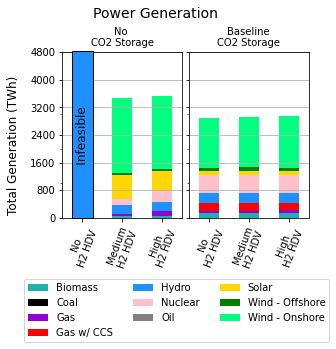

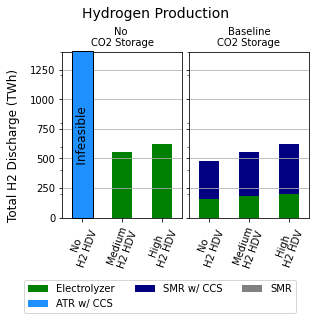

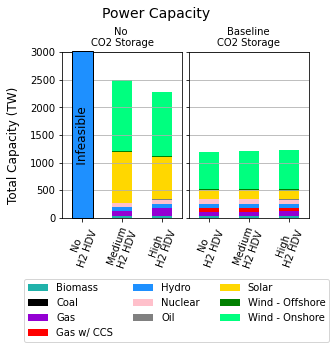

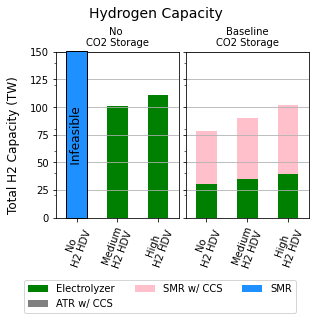

In [258]:
fig_compare_new(directory_name,[DATA_POWER_none[0], DATA_POWER_baseline[0]],
                "Power Generation",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "h2_hdv" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name,[DATA_H2_none[0], DATA_H2_baseline[0]],
                "Hydrogen Production",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "h2_hdv" , ylim = [-0, 1400], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

combine_images(directory_name,"/Figures/elec_h2_gen_h2_hdv",directory_name + 'Figures/elec_gen_h2_hdv.png', directory_name + 'Figures/h2_gen_h2_hdv.png')



fig_compare_new(directory_name,[DATA_POWER_none[1], DATA_POWER_baseline[1]],
                "Power Capacity",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "h2_hdv" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name,[DATA_H2_none[1], DATA_H2_baseline[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "h2_hdv" , ylim = [-0, 150], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

combine_images(directory_name,"/Figures/elec_h2_cap_h2_hdv",directory_name + 'Figures/elec_cap_h2_hdv.png', directory_name + 'Figures/h2_cap_h2_hdv.png')



### H2 HDV Sen Emissions

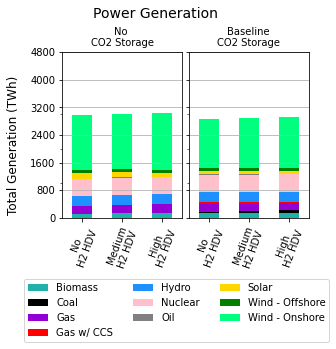

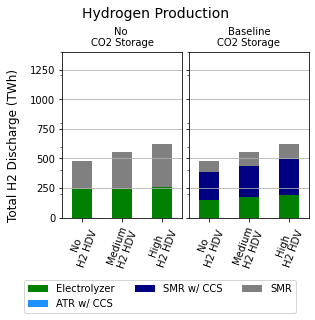

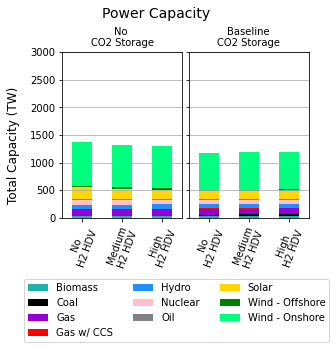

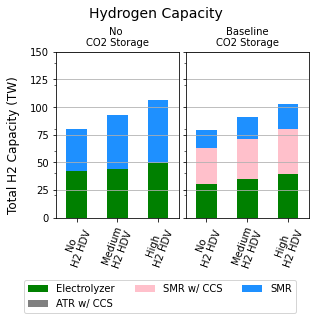

In [259]:
fig_compare_new(directory_name_sen_relaxed,[DATA_POWER_none_sen_relaxed[0], DATA_POWER_baseline_sen_relaxed[0]],
                "Power Generation",
                [s1_scenario_list_none_sen_relaxed_vals, s1_scenario_list_baseline_sen_relaxed_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "h2_hdv_relaxed" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [1.0],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name_sen_relaxed,[DATA_H2_none_sen_relaxed[0], DATA_H2_baseline_sen_relaxed[0]],
                "Hydrogen Production",
                [s1_scenario_list_none_sen_relaxed_vals, s1_scenario_list_baseline_sen_relaxed_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "h2_hdv_relaxed" , ylim = [-0, 1400], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [1.0],
               legend_loc = [0,-0.1])

combine_images(directory_name_sen_relaxed,"/Figures/elec_h2_gen_h2_hdv_relaxed",
               directory_name_sen_relaxed + 'Figures/elec_gen_h2_hdv_relaxed.png',
               directory_name_sen_relaxed + 'Figures/h2_gen_h2_hdv_relaxed.png')


fig_compare_new(directory_name_sen_relaxed,[DATA_POWER_none_sen_relaxed[1], DATA_POWER_baseline_sen_relaxed[1]],
                "Power Capacity",
                [s1_scenario_list_none_sen_relaxed_vals, s1_scenario_list_baseline_sen_relaxed_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "h2_hdv_relaxed" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [1.0],
               legend_loc = [0,-0.2])


fig_compare_new(directory_name_sen_relaxed,[DATA_H2_none_sen_relaxed[1], DATA_H2_baseline_sen_relaxed[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_none_sen_relaxed_vals, s1_scenario_list_baseline_sen_relaxed_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "h2_hdv_relaxed" , ylim = [-0, 150], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [1.0],
               legend_loc = [0,-0.1])

combine_images(directory_name_sen_relaxed,"/Figures/elec_h2_cap_h2_hdv_relaxed",directory_name_sen_relaxed + 'Figures/elec_cap_h2_hdv_relaxed.png',
               directory_name_sen_relaxed + 'Figures/h2_cap_h2_hdv_relaxed.png')

### H2 HDV NG Sen

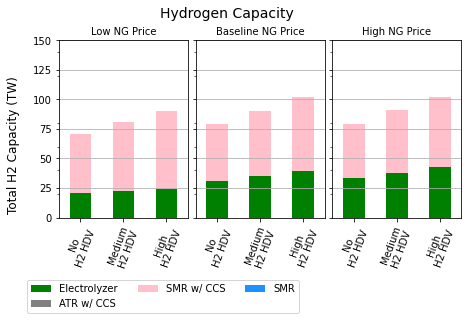

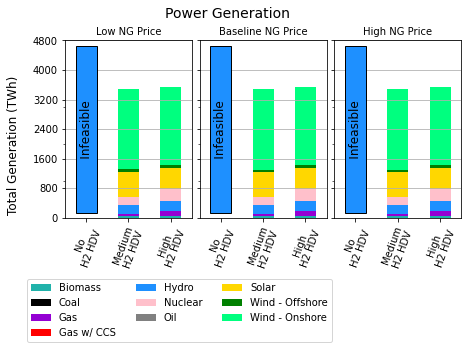

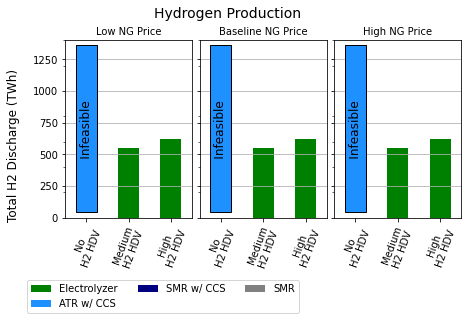

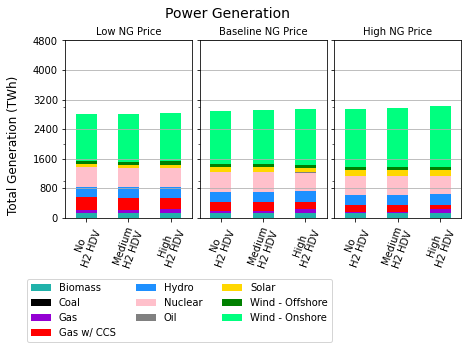

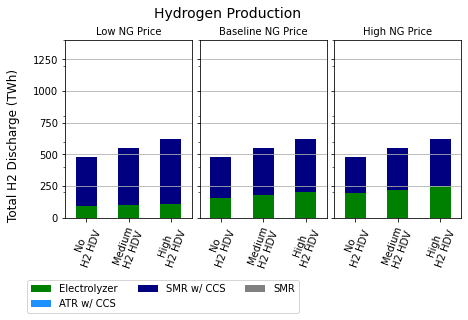

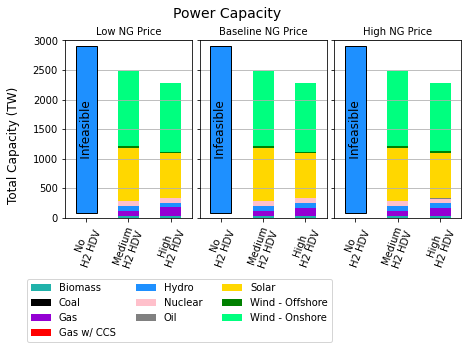

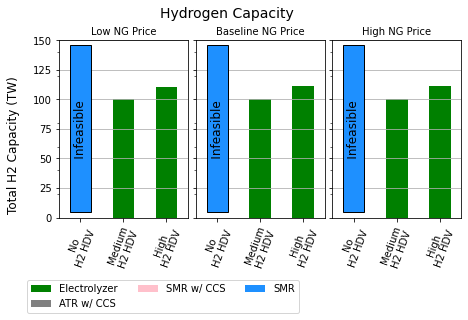

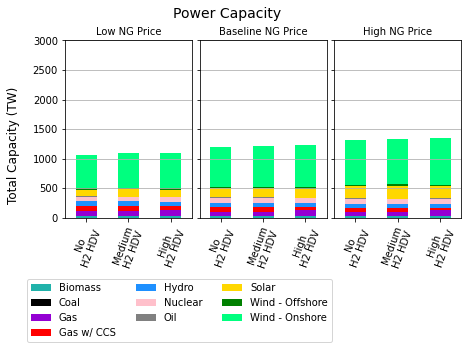

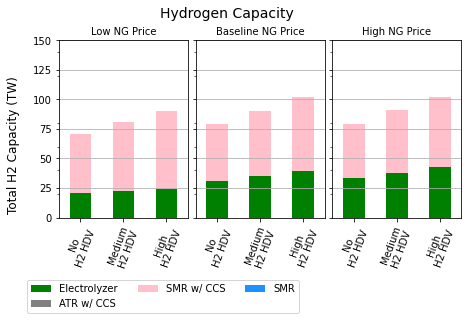

In [260]:
fig_compare_new(directory_name_sen_ng_high,[DATA_POWER_none_sen_ng_low[0], DATA_POWER_none[0], DATA_POWER_none_sen_ng_high[0]],
                "Power Generation",
                [s1_scenario_list_none_sen_ng_low_vals, s1_scenario_list_none_vals, s1_scenario_list_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "h2_hdv_sen_ng_none" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name_sen_ng_high,[DATA_H2_none_sen_ng_low[0], DATA_H2_none[0], DATA_H2_none_sen_ng_high[0]],
                "Hydrogen Production",
                [s1_scenario_list_none_sen_ng_low_vals, s1_scenario_list_none_vals, s1_scenario_list_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "h2_hdv_sen_ng_none" , ylim = [-0, 1400], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

combine_images(directory_name_sen_ng_high,"/Figures/elec_h2_gen_h2_hdv_sen_ng_none",directory_name_sen_ng_high + 'Figures/elec_gen_h2_hdv_sen_ng_none.png',
               directory_name_sen_ng_high + 'Figures/h2_gen_h2_hdv_sen_ng_none.png')


fig_compare_new(directory_name_sen_ng_high,[DATA_POWER_baseline_sen_ng_low[0], DATA_POWER_baseline[0], DATA_POWER_baseline_sen_ng_high[0]],
                "Power Generation",
                [s1_scenario_list_baseline_sen_ng_low_vals, s1_scenario_list_baseline_vals, s1_scenario_list_baseline_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "h2_hdv_sen_ng_baseline" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name_sen_ng_high,[DATA_H2_baseline_sen_ng_low[0], DATA_H2_baseline[0], DATA_H2_baseline_sen_ng_high[0]],
                "Hydrogen Production",
                [s1_scenario_list_baseline_vals, s1_scenario_list_baseline_vals, s1_scenario_list_baseline_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "h2_hdv_sen_ng_baseline" , ylim = [-0, 1400], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

combine_images(directory_name_sen_ng_high,"/Figures/elec_h2_gen_h2_hdv_sen_ng_baseline",directory_name_sen_ng_high + 'Figures/elec_gen_h2_hdv_sen_ng_baseline.png',
               directory_name_sen_ng_high + 'Figures/h2_gen_h2_hdv_sen_ng_baseline.png')


fig_compare_new(directory_name_sen_ng_high,[DATA_POWER_none_sen_ng_low[1], DATA_POWER_none[1], DATA_POWER_none_sen_ng_high[1]],
                "Power Capacity",
                [s1_scenario_list_none_sen_ng_low_vals, s1_scenario_list_none_vals, s1_scenario_list_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "h2_hdv_sen_ng_none" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name_sen_ng_high,[DATA_H2_none_sen_ng_low[1], DATA_H2_none[1], DATA_H2_none_sen_ng_high[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_none_sen_ng_low_vals, s1_scenario_list_none_vals, s1_scenario_list_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "h2_hdv_sen_ng_none" , ylim = [-0, 150], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])


fig_compare_new(directory_name_sen_ng_high,[DATA_POWER_baseline_sen_ng_low[1], DATA_POWER_baseline[1], DATA_POWER_baseline_sen_ng_high[1]],
                "Power Capacity",
                [s1_scenario_list_baseline_sen_ng_low_vals, s1_scenario_list_baseline_vals, s1_scenario_list_baseline_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "h2_hdv_sen_ng_baseline" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV',  'High\nH2 HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])



fig_compare_new(directory_name_sen_ng_high,[DATA_H2_baseline_sen_ng_low[1], DATA_H2_baseline[1], DATA_H2_baseline_sen_ng_high[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_baseline_vals, s1_scenario_list_baseline_vals, s1_scenario_list_baseline_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "h2_hdv_sen_ng_baseline" , ylim = [-0, 150], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nH2 HDV','Medium\nH2 HDV', 'High\nH2 HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])




### SF HDV

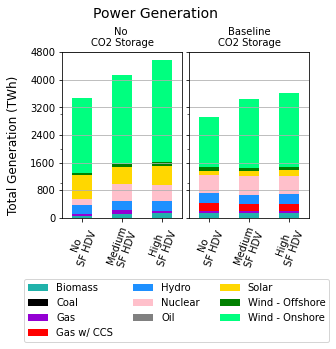

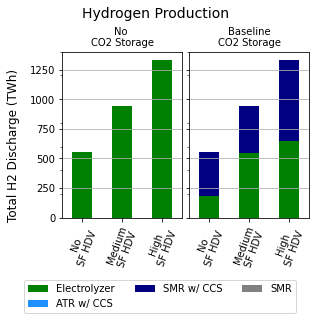

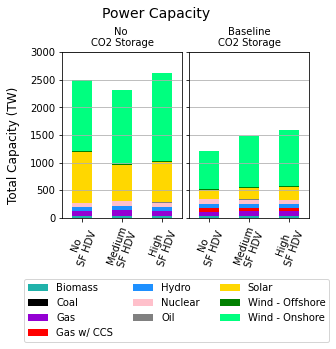

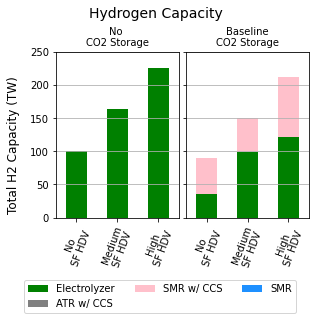

In [261]:
fig_compare_new(directory_name_sf,[DATA_POWER_sf_none[0],DATA_POWER_sf_baseline[0]],
                "Power Generation",
                [s1_scenario_list_sf_none_vals, s1_scenario_list_sf_baseline_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "sf_hdv" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf,[DATA_H2_sf_none[0],DATA_H2_sf_baseline[0]],
                "Hydrogen Production",
                [s1_scenario_list_sf_none_vals, s1_scenario_list_sf_baseline_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "sf_hdv" , ylim = [0, 1400], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4], 
               legend_loc = [0,-0.1])

combine_images(directory_name_sf,"/Figures/elec_h2_gen_sf_hdv",directory_name_sf + 'Figures/elec_gen_sf_hdv.png', directory_name_sf + 'Figures/h2_gen_sf_hdv.png')


fig_compare_new(directory_name_sf,[DATA_POWER_sf_none[1],DATA_POWER_sf_baseline[1]],
                "Power Capacity",
                [s1_scenario_list_sf_none_vals, s1_scenario_list_sf_baseline_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "sf_hdv" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf,[DATA_H2_sf_none[1],DATA_H2_sf_baseline[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_sf_none_vals, s1_scenario_list_sf_baseline_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "sf_hdv" , ylim = [0, 250], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4], 
               legend_loc = [0,-0.1])

combine_images(directory_name_sf,"/Figures/elec_h2_cap_sf_hdv",directory_name_sf + 'Figures/elec_cap_sf_hdv.png', directory_name_sf + 'Figures/h2_cap_sf_hdv.png')


In [256]:
DATA_POWER_sf_none[1][0]

,resource_type,EndCap,scenario,capacity_gw,co2_percent,h2_percent,sf_percent
0,Battery,1.680586e+05,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",1.680586e+02,0.4,0.5,0.0
1,Biomass,2.376350e+04,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",2.376350e+01,0.4,0.5,0.0
2,Coal,4.321621e-06,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",4.321621e-09,0.4,0.5,0.0
3,Gas,9.706181e+04,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",9.706181e+01,0.4,0.5,0.0
4,Gas w/ CCS,1.902438e-06,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",1.902438e-09,0.4,0.5,0.0
5,Hydro,7.275902e+04,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",7.275902e+01,0.4,0.5,0.0
6,Nuclear,8.225500e+04,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",8.225500e+01,0.4,0.5,0.0
7,Oil,2.420658e-05,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",2.420658e-08,0.4,0.5,0.0
8,PHS,1.407700e+04,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",1.407700e+01,0.4,0.5,0.0
9,Solar,9.107137e+05,"50% H2, 40% CO2 Cap, 0% SF,\n No CO2 Storage",9.107137e+02,0.4,0.5,0.0


In [248]:
DATA_POWER_sf_none[1][0]["capacity_gw"].sum()

2671.5707674452615

In [249]:
DATA_POWER_sf_none[1][1]["capacity_gw"].sum()

2373.479097112946

In [250]:
DATA_POWER_sf_none[1][2]["capacity_gw"].sum()

2689.9721119814576

### SF HDV H2 Sen

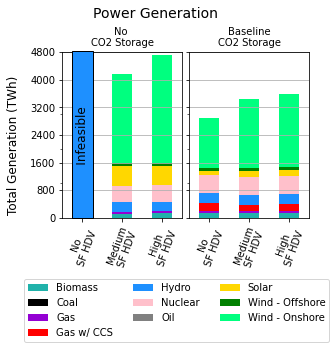

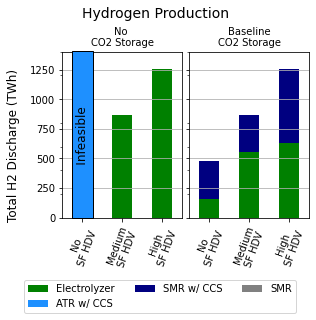

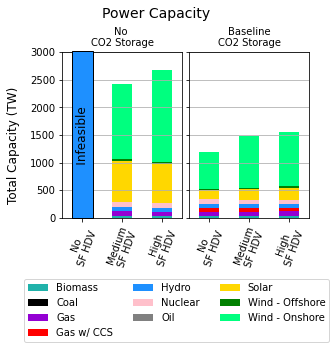

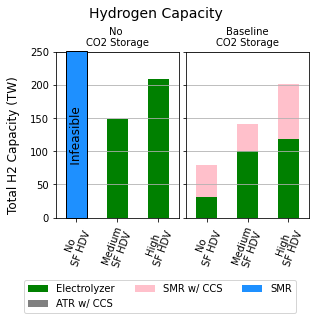

In [262]:
fig_compare_new(directory_name_sf_sen_h2,[DATA_POWER_sf_none_sen_h2[0],DATA_POWER_sf_baseline_sen_h2[0]],
                "Power Generation",
                [s1_scenario_list_sf_none_sen_h2_vals, s1_scenario_list_sf_baseline_sen_h2_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "sf_hdv_sen_h2" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf_sen_h2,[DATA_H2_sf_none_sen_h2[0],DATA_H2_sf_baseline_sen_h2[0]],
                "Hydrogen Production",
                [s1_scenario_list_sf_none_sen_h2_vals, s1_scenario_list_sf_baseline_sen_h2_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "sf_hdv_sen_h2" , ylim = [0, 1400], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4], 
               legend_loc = [0,-0.1])

combine_images(directory_name_sf_sen_h2,"/Figures/elec_h2_gen_sf_hdv_sen_h2",
               directory_name_sf_sen_h2 + 'Figures/elec_gen_sf_hdv_sen_h2.png',
               directory_name_sf_sen_h2 + 'Figures/h2_gen_sf_hdv_sen_h2.png')


fig_compare_new(directory_name_sf_sen_h2,[DATA_POWER_sf_none_sen_h2[1],DATA_POWER_sf_baseline_sen_h2[1]],
                "Power Capacity",
                [s1_scenario_list_sf_none_sen_h2_vals, s1_scenario_list_sf_baseline_sen_h2_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "sf_hdv_sen_h2" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf_sen_h2,[DATA_H2_sf_none_sen_h2[1],DATA_H2_sf_baseline_sen_h2[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_sf_none_sen_h2_vals, s1_scenario_list_sf_baseline_sen_h2_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "sf_hdv_sen_h2" , ylim = [0, 250], reorder_groups = True,
                subplot_titles = ["No \nCO2 Storage", "Baseline\nCO2 Storage"],
                labels = ['No\nSF HDV', 'Medium\nSF HDV', 'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4], 
               legend_loc = [0,-0.1])

combine_images(directory_name_sf_sen_h2,"/Figures/elec_h2_cap_sf_hdv_sen_h2",
               directory_name_sf_sen_h2 + 'Figures/elec_cap_sf_hdv_sen_h2.png',
               directory_name_sf_sen_h2 + 'Figures/h2_cap_sf_hdv_sen_h2.png')


### SF HDV NG Sen

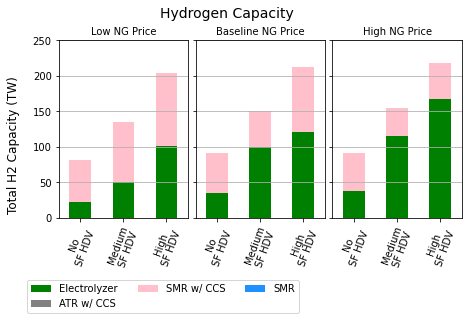

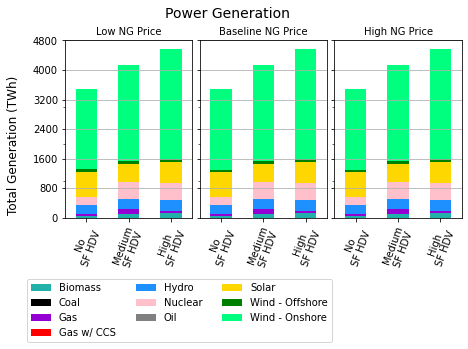

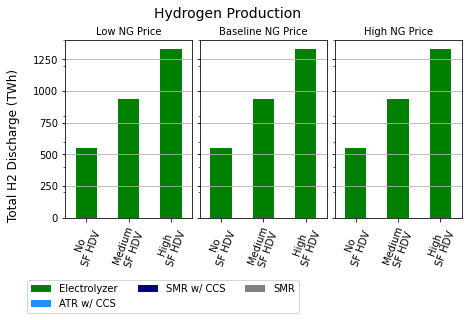

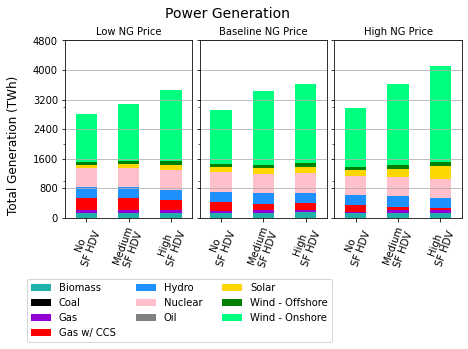

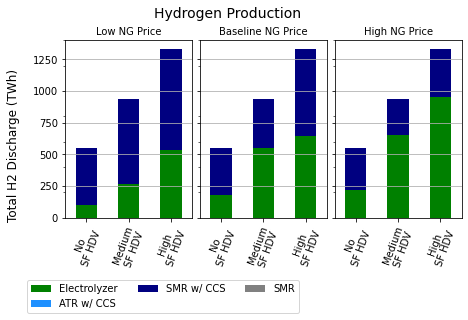

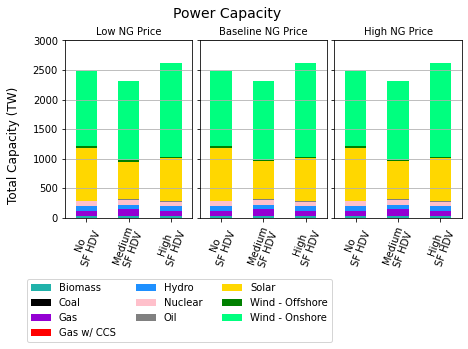

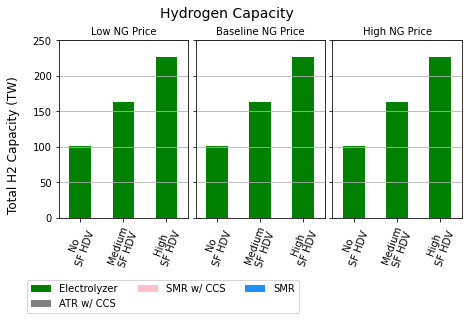

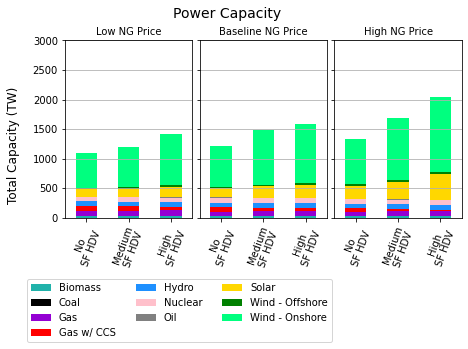

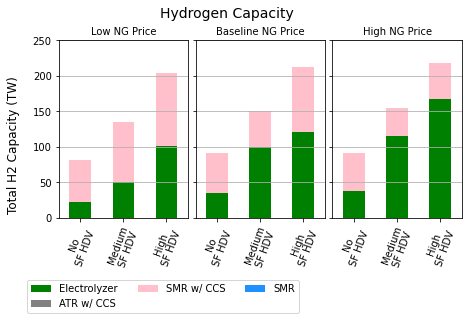

In [319]:
fig_compare_new(directory_name_sf_sen_ng,[DATA_POWER_sf_none_sen_ng_low[0], DATA_POWER_sf_none[0], DATA_POWER_sf_none_sen_ng_high[0]],
                "Power Generation",
                [s1_scenario_list_sf_none_sen_ng_low_vals, s1_scenario_list_sf_none_vals, s1_scenario_list_sf_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "sf_hdv_sen_ng_none" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf_sen_ng,[DATA_H2_sf_none_sen_ng_low[0], DATA_H2_sf_none[0], DATA_H2_sf_none_sen_ng_high[0]],
                "Hydrogen Production",
                [s1_scenario_list_sf_none_sen_ng_low_vals, s1_scenario_list_sf_none_vals, s1_scenario_list_sf_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "sf_hdv_sen_ng_none" , ylim = [-0, 1400], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

fig_compare_new(directory_name_sf_sen_ng,[DATA_POWER_sf_baseline_sen_ng_low[0], DATA_POWER_sf_baseline[0], DATA_POWER_sf_baseline_sen_ng_high[0]],
                "Power Generation",
                [s1_scenario_list_sf_baseline_sen_ng_low_vals, s1_scenario_list_sf_baseline_vals, s1_scenario_list_sf_baseline_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "sf_hdv_sen_ng_baseline" , ylim = [0, 4800], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])


fig_compare_new(directory_name_sf_sen_ng,[DATA_H2_sf_baseline_sen_ng_low[0], DATA_H2_sf_baseline[0], DATA_H2_sf_baseline_sen_ng_high[0]],
                "Hydrogen Production",
                [s1_scenario_list_sf_baseline_sen_ng_low_vals, s1_scenario_list_sf_baseline_vals, s1_scenario_list_sf_baseline_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "sf_hdv_sen_ng_baseline" , ylim = [-0, 1400], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

### CAP

fig_compare_new(directory_name_sf_sen_ng,[DATA_POWER_sf_none_sen_ng_low[1], DATA_POWER_sf_none[1], DATA_POWER_sf_none_sen_ng_high[1]],
                "Power Capacity",
                [s1_scenario_list_sf_none_sen_ng_low_vals, s1_scenario_list_sf_none_vals, s1_scenario_list_sf_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "sf_hdv_sen_ng_none" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf_sen_ng,[DATA_H2_sf_none_sen_ng_low[1], DATA_H2_sf_none[1], DATA_H2_sf_none_sen_ng_high[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_sf_none_sen_ng_low_vals, s1_scenario_list_sf_none_vals, s1_scenario_list_sf_none_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "sf_hdv_sen_ng_none" , ylim = [-0, 250], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])

fig_compare_new(directory_name_sf_sen_ng,[DATA_POWER_sf_baseline_sen_ng_low[1], DATA_POWER_sf_baseline[1], DATA_POWER_sf_baseline_sen_ng_high[1]],
                "Power Capacity",
                [s1_scenario_list_sf_baseline_sen_ng_low_vals, s1_scenario_list_sf_baseline_vals, s1_scenario_list_sf_baseline_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "elec_cap", relative = False, scenario_save = "sf_hdv_sen_ng_baseline" , ylim = [0, 3000], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels =  ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.2])

fig_compare_new(directory_name_sf_sen_ng,[DATA_H2_sf_baseline_sen_ng_low[1], DATA_H2_sf_baseline[1], DATA_H2_sf_baseline_sen_ng_high[1]],
                "Hydrogen Capacity",
                [s1_scenario_list_sf_baseline_sen_ng_low_vals, s1_scenario_list_sf_baseline_vals, s1_scenario_list_sf_baseline_sen_ng_high_vals],
                group_by_CO2_cap = True, plot_type = "h2_cap", relative = False, scenario_save = "sf_hdv_sen_ng_baseline" , ylim = [-0, 250], reorder_groups = True,
                subplot_titles = ["Low NG Price", "Baseline NG Price","High NG Price"],
                labels = ['No\nSF HDV','Medium\nSF HDV',  'High\nSF HDV'],
                y_labels = ["", ""],
               co2_include = [0.4],
               legend_loc = [0,-0.1])


# Paper Calcs

## H2 Results

In [285]:
# Incrremental Demand Due to H2

print("Incremental Demand due to H2")

non_trans_elec_demand = 2080.99
non_trans_h2_demand = 468.39

h2_hdv_med_h2_cons = DATA_H2_none[0][0]["h2_prod"].sum()*(33.3*1e9*1e-12)  #["generation_twh"].sum()
h2_hdv_high_h2_cons = DATA_H2_none[0][1]["h2_prod"].sum()*(33.3*1e9*1e-12)  #["generation_twh"].sum()

h2_hdv_med_power_cons = round((h2_hdv_med_h2_cons -  non_trans_h2_demand)* 45/33.3,2)
h2_hdv_high_power_cons = round((h2_hdv_high_h2_cons -  non_trans_h2_demand)* 45/33.3,2)

h2_elec_cons_med_percent = round((h2_hdv_med_h2_cons -  non_trans_h2_demand)* 45/33.3 /non_trans_elec_demand*100,2)
h2_elec_cons_high_percent = round((h2_hdv_high_h2_cons -  non_trans_h2_demand)* 45/33.3 /non_trans_elec_demand*100,2)


print(f"Use of H$_2$ for HDVs, however, resolves the model infeasibility and leads to incremental H$_2$ supply via electrolytic hydrogen production that consumes {h2_hdv_med_power_cons}-{h2_hdv_high_power_cons} TWh of electricity or approximately {h2_elec_cons_med_percent}-{h2_elec_cons_high_percent}\% of non-H$_2$ sector electricity demand")




Incremental Demand due to H2
Use of H$_2$ for HDVs, however, resolves the model infeasibility and leads to incremental H$_2$ supply via electrolytic hydrogen production that consumes 110.08-206.17 TWh of electricity or approximately 5.29-9.91\% of non-H$_2$ sector electricity demand


In [306]:
DATA_H2_baseline_sen_ng_low[0][1].query("resource_type == 'Electrolyzer'")["h2_prod"].sum()*(33.3*1e9*1e-12)  
DATA_H2_baseline_sen_ng_high[0][1].query("resource_type == 'Electrolyzer'")["h2_prod"].sum()*(33.3*1e9*1e-12)  #["generation_twh"].sum()

#h2_hdv_high_h2_cons = DATA_H2_none[0][1]["h2_prod"].sum()*(33.3*1e9*1e-12)

print(f"Cost savings low price:{cost_diff_calc(DATA_COST_baseline_sen_ng_low).percent_diff_first[2]}")
print(f"Cost savings high price:{cost_diff_calc(DATA_COST_baseline_sen_ng_high).percent_diff_first[2]}")
#cost_diff_calc(DATA_COST_baseline_sen_relaxed)

Cost savings low price:-13.183546461318778
Cost savings high price:-11.20805801348246


In [314]:
print(f"CO2 Seq low NG price: {DATA_EMISSIONS_baseline_sen_ng_low[0]['CO2 Storage'][1]}")
print(f"CO2 Seq high NG price: {DATA_EMISSIONS_baseline_sen_ng_high[0]['CO2 Storage'][1]}")

CO2 Seq low NG price: 273.36710230318414
CO2 Seq high NG price: 163.26556899180224


In [325]:
print(f"Cost siff sf:{cost_diff_calc(DATA_COST_sf_baseline_sen_ng_low).percent_diff_first[2]}")
print(f"Cost siff sf:{cost_diff_calc(DATA_COST_sf_baseline_sen_ng_high).percent_diff_first[2]}")
#print(f"Cost savings high price:{cost_diff_calc(DATA_COST_baseline_sen_ng_high).percent_diff_first[2]}")
#cost_diff_calc(DATA_COST_baseline_sen_relaxed)

print(f"Cost siff sf:{cost_diff_calc(DATA_COST_sf_none_sen_ng_low).percent_diff_first[2]}")
print(f"Cost siff sf:{cost_diff_calc(DATA_COST_sf_none_sen_ng_high).percent_diff_first[2]}")

Cost siff sf:32.975911407292635
Cost siff sf:34.331467522574115
Cost siff sf:14.763478565673644
Cost siff sf:16.778425507575562


In [328]:
DATA_H2_sf_baseline_sen_ng_low[0][1].query("resource_type == 'Electrolyzer'")["h2_prod"].sum()*(33.3*1e9*1e-12)  
DATA_H2_sf_baseline_sen_ng_high[0][1].query("resource_type == 'Electrolyzer'")["h2_prod"].sum()*(33.3*1e9*1e-12)  #["generation_twh"].sum()


647.9110779837947

# EXTRA CapacityEXTR

### Power and Hydrogen Production Comparison

In [ ]:
fig_compare_new( directory_name,[DATA_POWER_none[0],DATA_POWER_no_only_new[0], DATA_POWER_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-320, 400], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])

fig_compare_new( directory_name,[DATA_H2_none[0],DATA_H2_no_only_new[0], DATA_H2_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "dual_rel" , ylim = [-120, 250], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])



fig_compare_new( directory_name,[DATA_POWER_none[0],DATA_POWER_no_only_new[0], DATA_POWER_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "elec", relative = False, scenario_save = "dual_rel" , ylim = [0, 4000], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])

fig_compare_new( directory_name,[DATA_H2_none[0],DATA_H2_no_only_new[0], DATA_H2_baseline_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_none_vals, s1_scenario_list_no_only_new_vals, s1_scenario_list_baseline_vals_new],
                group_by_CO2_cap = True, plot_type = "h2", relative = False, scenario_save = "dual_rel" , ylim = [0, 700], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'],
               y_labels = ["No \nCO2 Storage", "NO Only\nCO2 Storage", "Baseline\nCO2 Storage"])

fig_compare_new(directory_name,[DATA_POWER_baseline_new[0], DATA_POWER_no_only_new[0]],
                "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                [s1_scenario_list_baseline_vals_new, s1_scenario_list_no_only_new_vals],
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-300, 200], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'],
               y_labels = ["Baseline\nCO2 Storage", "NO Only\nCO2 Storage"])




fig_compare_new(directory_name,DATA_POWER_baseline_new[0], DATA_POWER_no_only_new[0],  "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_baseline_vals_new, index_ordered_2 = s1_scenario_list_no_only_new_vals,
                group_by_CO2_cap = True, plot_type = "elec", relative = True, scenario_save = "dual_rel" , ylim = [-300, 200], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'])


fig_compare_new(directory_name,DATA_H2_baseline_new[0], DATA_H2_no_only_new[0], "H2 Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_baseline_vals_new, index_ordered_2 = s1_scenario_list_no_only_new_vals,
                group_by_CO2_cap = True, plot_type = "h2", relative = True, scenario_save = "dual_rel" , ylim = [-110, 230], reorder_groups = True,
               subplot_titles = ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                labels = ['No\nH2 HDV', 'Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'])



### Power and H2 Comp Absolute

In [ ]:
fig_compare_abs(directory_name,[DATA_POWER_baseline_new, DATA_POWER_no_only_new, DATA_POWER_none], [DATA_H2_baseline_new, DATA_H2_no_only_new, DATA_H2_none],
                "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios",
                [s1_scenario_list_baseline_vals_new, s1_scenario_list_baseline_vals_new, s1_scenario_list_baseline_vals_new],
                 group_by_CO2_cap = False, relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3500],ylim_2 = [0, 2500], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True,
               column_titles = ["Baseline CO2 Storage", "NO Only CO2 Storage", "No CO2 Storage"])


fig_compare_abs(directory_name,[DATA_POWER_baseline_new, DATA_POWER_no_only_new], [DATA_H2_baseline_new, DATA_H2_no_only_new],
                "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios",
                [s1_scenario_list_baseline_vals_new, s1_scenario_list_baseline_vals_new],
                 group_by_CO2_cap = False, relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3500],ylim_2 = [0, 2100], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True)

fig_compare_abs(directory_name,
                [DATA_POWER_baseline, DATA_POWER_no_only],
                [DATA_H2_baseline, DATA_H2_no_only],
                "Absolute Power and Hydrogen Generation and Capacity \n For Low H2 HDV Adoption Across Emission Cap Scenarios",
                [s1_scenario_list_baseline_vals,s1_scenario_list_baseline_vals],
                group_by_CO2_cap = False, relative = False, scenario_save = "dual_rel" , ylim_1 = [0, 3500],ylim_2 = [0, 2100], 
                ylim_3 = [0, 550], ylim_4 = [0, 100], reorder_groups = True)



### Emissions

In [ ]:
co2_percent_values = [0.4, 1.0]
create_double_subplots_for_co2_percent([DATA_EMISSIONS_none[0],DATA_EMISSIONS_no_only_new[0], DATA_EMISSIONS_baseline_new[0]], co2_percent_values, [0,400],
                                       ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
                                       ["No CO2 Storage","NO Only CO2 Storage", "Baseline CO2 Storage"  ],
                                       fig_type = "no_sf")

create_double_subplots_for_co2_percent([DATA_EMISSIONS_baseline_new[0], DATA_EMISSIONS_no_only_new[0], DATA_EMISSIONS_none[0]], co2_percent_values, [0,400],
                                       ['No\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV'],
                                       ["103 Mtonne CO2 Cap", "155 Mtonne CO2 Cap", "206 Mtonne CO2 Cap", "258 Mtonne CO2 Cap"],
                                       fig_type = "no_sf")

### Cost

In [ ]:
plot_cost_dual(df_list = [ DATA_COST_baseline_new,DATA_COST_no_only_new,DATA_COST_none],
               dist_lower = [1.1, 2.21, 3.31,4.42,0],
                 dist_upper = [1.73, 3.46, 5.19, 6.93,0],
                 title = 'Cost Breakdown by Emissions and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = False, 
                 save_name =  'dual',
                 group_by = "CO2",
                 ylim = [-65,15],
              plot_dist = False)


plot_cost_dual(df_1 = DATA_COST_baseline,
               df_2 = DATA_COST_no_only,
               dist_lower = [1.1, 2.21, 3.31,4.42],
                 dist_upper = [1.73, 3.46, 5.19, 6.93],
                 title = 'Cost Breakdown by Emissions and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "CO2",
                 ylim = [-32,12],
              plot_dist = True)




## SF Figures

### Power and Hydrogen Comparison

In [ ]:
fig_compare_new(directory_name_sf,DATA_POWER_sf_baseline[0], DATA_POWER_sf_no_only[0],  "Power Generation Across Emissions and H2 HDV Adoption Scenarios",
                    index_ordered_1 = s1_scenario_list_sf_baseline_vals,index_ordered_2 = s1_scenario_list_sf_no_only_vals,
                group_by_CO2_cap = False, 
                plot_type = "elec", relative = True, scenario_save = "sf_dual_rel" , ylim = [-50, 200], reorder_groups = False)


fig_compare_new(directory_name_sf,DATA_H2_sf_baseline[0], DATA_H2_sf_no_only[0],  "H2 Generation Across Emissions and H2 HDV Adoption Scenarios",
                index_ordered_1 = s1_scenario_list_sf_baseline_vals,index_ordered_2 = s1_scenario_list_sf_no_only_vals,
            group_by_CO2_cap = False, plot_type = "h2", relative = True, scenario_save = "sf_dual_rel" , ylim = [-30, 130], reorder_groups = False)

### Emissions

In [ ]:
sf_percent_values = [0.00,0.05,0.10,0.15,0.20]
   
create_double_subplots_for_co2_percent(DATA_EMISSIONS_sf_baseline[0], DATA_EMISSIONS_sf_no_only[0], sf_percent_values, [0,380],
                                      ['Low\nH2 HDV', 'Medium\nH2 HDV', 'High\nH2 HDV', 'High\nH2 HDV'],
                                      ['0% SF', '5% SF', '10% SF', '15% SF', '20% SF'], fig_type = "sf")

### Cost

In [ ]:
plot_cost_dual(df_1 = DATA_COST_sf_baseline,
               df_2 = DATA_COST_sf_no_only,
               dist_lower = None,
                 dist_upper = None,
                 title = 'Cost Breakdown by SF and HDV Adoption Scenario',
                 dir_name = directory_name,
                 relative = True, 
                 save_name =  'dual',
                 group_by = "h2",
                 ylim = [-5,15],
              plot_dist = False)
